<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; width: 100%;">
        <img src="doc_images/uniba2.png" alt="Immagine 1" style="width: 80%; height: auto;">
    </div>
</div>
<hr>
<br><br>

<h1><center>Documentazione Caso di Studio Ingegneria della Conoscenza<br>
    Gestione del Carico delle Richieste Intelligente</center></h1>
    
<h1><center>A.A. 2023/2024</center></h1>



<br><br>

<h3>Componenti gruppo:</h3>  
<p>Stefano Romanelli, [MAT. 709725], <a href="mailto:s.romanelli5@studenti.uniba.it">s.romanelli5@studenti.uniba.it</a></p>


<h3>Repository GitHub</h3>  
<p><a href="https://github.com/RayCatcherS/KnowledgeEngineeringProject">https://github.com/RayCatcherS/KnowledgeEngineeringProject</a></p>

<h4>Note</h4>  
<p>Il file può essere eseguito in qualsiasi IDE che supporti file .ipynb (jupyter notebook).</p>

<br><br>

<hr>

### Indice
* [1) Introduzione](#1)
    * [1.1) Scenario](#1.1)
    * [1.2) Obiettivi](#1.2)
    * [1.3) Formalizzazione obiettivi](#1.3)
    * [1.3.1) Obiettivi scenario sotto carico](#1.3.1)        
    * [1.3.2) Obiettivi scenario sovraccarico](#1.3.2) 
    * [1.4) Strumenti usati per affrontare gli obiettivi](#1.4) 
* [2) Dataset](#2)
    * [2.1) Pre-processing dataset conoscenza pregressa](#2.1)
* [3) Apprendimento Non Supervisionato](#3)
* [4) Constrained Optimization Problem](#4)
    * [4.1) Google OR-Tools](#4.1)
    * [4.2) Configurazione scenario](#4.2)
    * [4.3) Codifica Variabili](#4.3)
    * [4.4) Hard constraint](#4.4)
    * [4.5) Funzione Obiettivo - Soft Constraints](#4.5)
        * [4.5.1) Suddivisione del problema in due istanze](#4.5.1)
        * [4.5.2) Costruzione termini penalità funzione obiettivo_1 - istanza di sotto carico](#4.5.2)
        * [4.5.3) Esecuzione dello scenario di sotto carico](#4.5.3)
        * [4.5.4) Costruzione termini penalità funzione obiettivo_2 - istanza di sovraccarico](#4.5.4)
        * [4.5.5) Esecuzione dello scenario di sovraccarico](#4.5.5)
    * [4.6) Considerazioni finali](#4.6)
    * [4.7) Prestazioni e ottimalità](#4.7)
* [5) Monitoraggio del Sistema con Prolog](#5)
    
<hr>

# 1) Introduzione <a class="anchor" id="1"></a>


[Risultati su studi](https://www.sciencedirect.com/science/article/abs/pii/S1875952117300770) che intercettano i fattori di abbandono dai servizi di giochi online multigiocatore, mostrano che le motivazioni più rilevanti sono: 
- problemi di attesa, latenza/prestazioni(più rilevanti)
- l'equità del gioco(divario tra giocatori).

## 1.1) Scenario <a class="anchor" id="1.1"></a>
Si simula lo scenario in cui deve essere avviato un nuovo servizio online per il lancio di un nuovo gioco multiplayer. Periodicamente vengono fornite al sistema le informazioni sul carico, ovvero quantità delle richieste di partecipazione e la quantità delle risorse istanziabili(partite). Si assume ci siano due tipi di scenario:

**Scenario sovraccarico**: Generalmente si verifica nei primi giorni in cui il servizio diventa disponibile, il sovraccarico è dovuto al picco di giocatori. Si prevede lo scenario da gestire:

- Le risorse(partite) istanziabili e ed i posti assengabili sono più bassi delle richieste di partecipazione
- Le richieste di partecipazione dei giocatori saturano interamente le risorse istanziabili

**Scenario sotto carico**: Ad intermittenza sono previste anche fasi di sotto carico che il sistema deve essere in grado di gestire in modo ottimale, ottimizzando le risorse, investendole nel miglior modo possibile. Saper configurare correttamente le risorse nelle fasi di sotto carico permetterà di gestire meglio le fasi di sovraccarico. Lo scenario di sotto carico è caratterizzato da:
- Le risorse(partite) istanziabili e ed i posti assengabili sono più alti delle richieste di partecipazione
- Le richieste di partecipazione dei giocatori non saturano interamente le partite istanziabili

## 1.2) Obiettivi <a class="anchor" id="1.2"></a>
Sulla base di articoli di ricerca come quello citato nell'introduzione, è stato osservato che i giocatori tendono ad abbandonare i servizio di gaming online quando: l'attesa in coda è troppo lunga o le partite sono composte da giocatori con abilità troppo disomogenee. Le abilità disomogenee in una partita possono rendere l'esperienza di gioco squilibrata e frustrante. Inoltre, i giocatori che abbandonano frequentemente le partite tendono a creare numerosi buchi nelle partite stesse, rendendo lo stato complessivo del sistema poco ottimizzato. Le partite squilibrate potrebbero contribuire all'abbandono di partite avviate. Quello che si vuole fare tramite questo progetto è utilizzare modelli di apprendimento e di ricerca per migliorare e massimizzare l'uso di servizi online, scegliendo la giusta configurazione di utenza da servire nei servizi online 

## 1.3) Formalizzazione obiettivi <a class="anchor" id="1.3"></a>
I criteri per la formalizzazione delle specifiche degli obiettivi sono stati definiti sulla base delle considerazioni precedentemente discusse. Gli obiettivi mirano a massimizzare la permanenza dei giocatori nel servizio e a incentivare il loro utilizzo in diverse condizioni operative del servizio. 
Prima di passare ai due scenari principali, partendo da conoscenza pregressa raccolta dai giocatori iscritti alle scorse edizioni del servizio, si definiscono due obiettivi legati alla gestione dei giocatori della "stessa classe".

- Identificare classi di giocatori simili partendo da una selezionare features significative che possono identificare i giocatori rispetto alle loro abilità 
- classificare periodicamente i nuovi giocatori partendo dalle loro statistiche affinchè vengano assegnati ad una certa classe.

Dopodichè il problema si focalizza su due aspetti principali i cui obiettivi vengono scomposti in due scenari principali:
|


### 1.3.1) Obiettivi scenario sotto carico <a class="anchor" id="1.3.1"></a>
- **Assegnare giocatori:** Assegnare quanti più giocatori possibili alle partite disponibili
- **Riempimento totale partite:** I giocatori assegnati dovranno riempire completamente le partite massimizzando il loro utilizzo, evitando di sottodimensionare le partite. Questo consentirà di avere disponibili più partite istanziabili per le richieste successive o per eventuali fasi di sovraccarico.
- **Partite omogenee:** I giocatori all'interno delle partite devono essere di una classe omogenea, in altre parole le partite composte da giocatori simili rendono l'esperienza meno frustrante per i partecipanti.

### 1.3.2) Obiettivi scenario sovraccarico <a class="anchor" id="1.3.2"></a>
- **Partite di classi proporzionate** La distribuzione delle classi di giocatori che richiedono di partecipare a una partita dovrà riflettersi sulle partite istanziate. Se la distribuzione delle classi di giocatori nelle partite riflette la distribuzione complessiva di chi cerca di partecipare, garantisce che tutte le classi di giocatori avranno una giusta opportunità di partecipare alle partite, senza che ci sia una sottorappresentazione o una sovrarappresentazione di una classe particolare. Se la distribuzione è proporzionata alla domanda complessiva, si riduce la probabilità che una determinata classe di giocatori rimanga esclusa per un periodo di tempo troppo lungo. Inoltre sistribuendo in maniera uniforme le classi di giocatori rispetto alla popolazione, si ottimizzerà il numero di partite create, minimizzando la necessità di istanziare partite non piene o mal bilanciate, che potrebbero portare a un utilizzo inefficiente delle risorse disponibili.
- **Partite omogenee:** Le partite devono essere composte da giocatori simili(come nel sotto carico).
- **Preferire giocatori con basso quitting rate:** Preferire nella composizione delle partite giocatori con un basso tasso di abbandono in game. Questi giocatori con buona probabilità tendono ad abbandonare l'esperienza in game, creando degli spazi vuoti che non possono essere riempiti durante l'esecuzione della partita, peggiorando lo sfruttamento globale del sistema. Nello scenario di sovraccarico, ciò porta a sfruttare inefficientemente le risorse, aumentando possibili code di attesa, aumentando la probabilità di abbandono del servizio da parte degli utenti e comportando una penalizzazione sui guadagni complessivi dell'azienda.
- **Favorire i giocatori in attesa da più tempo:** I giocatori in attesa da più tempo saranno favoriti nella selezione per la composizione delle partite, evitando che questi abbandonino il servizio a causa di lunghe attese. Inoltre la preferenza sui *giocatori con basso quitting rate* potrebbe essere troppo avida, e molti giocatori con un tasso di quitting rate troppo alto potrebbero andare in **starvation**. Quest'ultimo punto evita che questo accadere, in quanto anche giocatori con quitting rate troppo alto prima o poi verranno favoriti rispetto al loro tempo di attesa in coda.

## 1.4) Strumenti usati per affrontare gli obiettivi <a class="anchor" id="1.4"></a>
**Clustering**: Un algoritmo di *apprendimento non supervisionato* permetterà di dividere in cluster(classi naturali) i giocatori rispetto ad una adeguata selezione delle features, permettendo la costruzione di partite equilibrate. L'algoritmo non supervisionato sfrutterà la conoscenza pregressa  sui giocatori iscritti alla piattaforma rispetto ai giochi precedentemente giocati.

**Classificazione**: L'apprendimento di un modello tramite *apprendimento supervisionato* permetterà di classificare periodicamente i nuovi giocatori in base alle loro statistiche, assegnando i nuovi giocatori ad una classe

**Ricerca per problemi di ottimizzazione vincolata**: Lo studio del progetto si concentrerà maggiormente sulla rappresentazione del problema definendolo in termini di uno spazio di ricerca formato da assegnazioni, in cui un algoritmo di ricerca risolverà un problema di ottimizzazione vincolata, esplorando le possibili configurazioni cercando una soluzione ottimale. I criteri e le specifiche degli obiettivi saranno utilizzati per formulare vincoli e funzioni obiettivo che consentiranno all'algoritmo di trovare soluzioni ottimali.

<hr>

# 2) Dataset <a class="anchor" id="2"></a>
Il primo tentativo per costruire il dataset è stato quello ottenere i dati di statistiche tramite web scraping su un sito di statistiche del gioco call of duty, ma a causa del tempo limitato e del rate limiting posto dalla piattaforma web, ho optato per cercare un dataset già costruito(generalemente dataset di questo tipo sono rarissimi).
Il dataset è ottenuto su [Kaggle](https://www.kaggle.com/datasets/fahadalqahtani/cod-vanguard-stats), è un campione di circa trecicimila tuple di statistiche su giocatori del gioco Call Of Duty Vanguard. Le features fornite sono:


- **matches**: Numero di partite multigiocatore giocate dal giocatore.
- **play_time**: Tempo totale trascorso dal giocatore giocando a Call of Duty, in ore.
- **kills**: Numero di uccisioni effettuate dal giocatore in tutte le sue partite.
- **deaths**: Numero di volte in cui il giocatore è stato ucciso nel gioco.
- **assists**: Numero di volte in cui il giocatore ha danneggiato un nemico ma un compagno di squadra ha completato l'uccisione. Un valore alto indica che altri giocatori tendono a completare o rubare l'uccisione iniziata dal giocatere.
- **headshots**: Numero di colpi alla testa inflitti ad altri giocatori.
- **suicides**: Numero di volte che il giocatore si è sucidato.
- **wins**: Numero di volte in cui il giocatore ha vinto una partita.
- **losses**: Numero totale di partite perse.
- **score**: Punti Esperienza (XP), una quantità numerica esclusiva per il multigiocatore che determina il livello e il progresso di un giocatore nel gioco.
- **missed_shots**: Numero di volte in cui il giocatore ha mancato il colpo.
- **hits_shots**: Numero di volte in cui il giocatore ha colpito un altro giocatore.


Questi dati rappresentano statistiche dei singoli giocatori generate dalla loro attività nelle partite online. Si assume ai fini del toy problem che il dataset ottenuto siano parte di conoscenza pregressa appartenente a statistiche del gioco di precedente generazione a cui i giocatori hanno giocato. Si utilizzano quindi questi dati per affrontare le fasi dei due scenari (sovraccarico, sotto carico).

# 2.1) Pre-processing dataset conoscenza pregressa <a class="anchor" id="2.1"></a>
In questa fase si utilizzano librerie e tecniche ampiamente note, per effettuare pre-processing sui dati grezzi

### Feature Derivation
Vengono costruite features derivate da quelle di partenza. Queste sono utili per i task successivi:
- **game_exits** = gamesPlayed - (wins + losses)
- **kd_ratio**: Rapporto uccisioni/morti, usando le features *deaths* e *kills*. Un giocatore con un valore più alto tenderà ad aver fatto molte più uccisioni che morti, contribuendo alla vittoria della partita.
[//]: #- **mh_ratio**: Rapporto colpi andati a segno/colpi non andati a segno, usando le features *hits_shots* e *missed_shots*. Un giocatore con un valore più alto tenderà a mettere a segno più colpi.

In [45]:
import pandas as pd

# carica dataset nel dataframe
df = pd.read_csv('datasets/cod_vanguard_player_stats_raw.csv')

# feature derivation
df['kd_ratio'] = df['kills'] / df['deaths']
# df['mh_ratio'] = df['hits_shots'] / df['missed_shots']
df['game_exits'] = df['matches'] - (df['wins'] + df['losses'])

### Data cleaning e rimozione duplicati
Questa fase di pre-processing consiste nell'applicare:
- **Data Cleaning**: Pulizia di dati con valori nulli e valori negativi(su 13 tuple ci sono 2 valori negativi probabilmente dovuti ad errori durante la raccolta dei dati). Ci sono circa 13 mila tuple, quelle difettose sono di gran lunga minori. Rimuovere le tuple problematiche non andrà ad inficiare l'informatività del dataset. 
- **Rimozione duplicati**
- **Rimozione di tuple anomale**: Visualizzando i dati in ordine, si nota che molto raramente alcune tuple hanno valore *missed_shots* pari a zero. Probabilmente a causa di anomalie. Queste tuple vengono eliminate, la numerosità del dataset ci permette di prendere questa decisione. Non sono state trovate altre anomalie.
- **Rappresentazione feature play_time**: Ricavare solo il dato numerico dei minuti totali partendo dal formato stringa hours minutes

In [46]:
# Data Cleaning - verifica dei valori mancanti
'''
print('-Verifica valori mancanti-')
print(df.isnull().sum())
'''
# rimozione valori negativi per le features
df = df[df['game_exits'] >= 0]


# rimozione duplicati
df.drop_duplicates(inplace=True)

# rimozione tuple anomale
df = df[df['missed_shots'] != 0]

# conversione stringa hours minutes in valore intero rappresentate i minuti
# funzione per convertire il formato in minuti totali
def convert_play_time_to_minutes(play_time_str):
    # split stringa
    parts = play_time_str.split(' ')
    hours = int(parts[0].replace('h', ''))
    minutes = int(parts[1].replace('m', ''))
    
    # tot minuti
    total_minutes = hours * 60 + minutes
    return total_minutes
# applicazione della funzione alla colonna "play_time" per convertire tutto in minuti
df['play_time'] = df['play_time'].apply(convert_play_time_to_minutes)


# salvataggio dataset preprocessed 
import os
file_path = 'datasets/df_preprocessed.csv'
if os.path.exists(file_path):
    os.remove(file_path)
    
df.to_csv(file_path, index=False)

### Outlier
Tramite boxplot delle singole features degli esempi, questi sono risultati essere coerenti con una distribuzione realistica e informativa, non ci sono valori eccessivamente anomali.

### Normalizzazione delle features
Una vulnerabilità del K-means è quello di essere sensibile a scale di features troppo differenti in termini di dimensioni. Si adopera quindi una tecnica di **scaling** per **standardizzazione** le features, features con scale trooppo grandi tendono a dominare. Per la normalizzazione viene usato **z-score** che trasforma la distribuzione di ogni features in una distribuzione normale standard con media 0 e deviazione standard 1. La standardizzazione(o generalmente normalizzazione) consentirà di rendere le diverse features comparabili tra loro, indipendentemente dalla loro scala originale di partenza.
Viene quindi generato un secondo dataset normalizzato per il task di apprendimento non supervisionato(K-means).

In [47]:
from sklearn.preprocessing import StandardScaler

dfPreStand = pd.read_csv('datasets/df_preprocessed.csv')

# scaling(z-score)
scaler = StandardScaler()
features_to_normalize = ['matches', 'play_time', 'kills', 'deaths', 'assists', 'headshots', 'suicides', 'wins', 'losses', 'score', 'missed_shots', 'hits_shots', 'game_exits']
dfPreStand[features_to_normalize] = scaler.fit_transform(dfPreStand[features_to_normalize])


# salvataggio del dataset per il k-means standardizzato
file_path = 'datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfPreStand.to_csv(file_path, index=False)

# 3) Apprendimento Non Supervisionato <a class="anchor" id="3"></a>
Tramite apprendimento non supervisionato si avvalora una certa features Y non conosciuta. Quello che si vuole fare è costruire una **classificazione naturale dei dati** che non conosciamo. Tramite clustering voglio quindi partizionare l'insieme dei giocatori secondo pattern e somiglianze nei dati. Queste somiglianze devono raggruppare giocatori con comportamenti/pattern di gioco simili. 

####  Utilità del clustering nel problema
Specificamente al nostro problema ci servirà intercettare le *k* classi di giocatori simili, da assegnare all'insieme degli esempi. Intercettare le k classi, servirà alla fase di ricerca per configurazione le istanze delle partite di gioco. Un algoritmo di ricerca vincolata utilizzerà l'informazione sulle classi per distribuire nelle partite giocatori della stessa classe, rendendo le partite equilibrate.
#### Scelta approccio e algoritmo
Ho valutato i due approcci Soft e Hard Clustering.

Il Soft Clustering permetterebbe di creare un sistema più flessibile in quanto ogni esempio apparterrebbe ad ogni classe con una certa distribuzione di probabilità. Rispetto agli algoritmi affrontati nel corso, però, l'algoritmo per il Soft Clustering(Expectation e Maximization) fa un'assunzione di indipendenza condizionata sulle variabili(Naive Bayes), assunzione che nel mio caso non potrei assicurare come realistica. Ho quindi optato per l'approccio di Hard Clustering utilizzando **K-means**. È stato scelto K-means anche per semplificare il problema successivo.

#### Scelta delle features per l'addestramento
La scelta delle features per l'addestramento non supervisionato è stata fatta in modo empirico rispetto ad assunzioni personali. L'obiettivo è stato quello di isolare le features che probabilmente riflettono lo stile di gioco dei giocatori. Le **features scelte** sono: *matches*, *play_time*, *kills*, *deaths*, *assists*, *headshots*, *score*, *missed_shots*, *hits_shots*
Il resto delle features sono state scartate per il clustering per i seguenti motivi:
- Features come *wins* e *losses*: Sono features che dicono poco sul giocatore, in quanto le squadre sono composte da più giocatori e rifletterebbero più il risultato di una squadra

#### Scelta del valore naturale di *K*
Un altro dettaglio da curare nel K-means è la scelta dell'iperparametro *k*, ovvero la quantità di classi con cui far lavorare l'algoritmo. Un modo per trovare il suo **valore naturale** è utilizzare la **regola del gomito**, che consiste nel partire da un certo *k* basso e incrementarlo via via, cercando il numero ottimale di cluster *k* fino a un masso di iterazioni. La regola consiste nel calcolare la **somma delle distanze quadratiche(inertia)** tra ogni esempio(punto nello spazio) e i centroidi assegnati(classe), selezionando il valore di k per il quale questa somma inizia a ridursi lentamente.

L'algoritmo viene quindi eseguito su *k* che varia da 1 a 11. Al metodo KMeans vengono passati i seguenti parametri:
- ***init='k-means++'***: È una tecnica di inizializzazione nella scelta i centroidi iniziali in modo più intelligente e non in modo casuale(ad esempio scegliendo centroidi distanti tra loro), questo aiuta ad innescare l'algoritmo, migliorandone la convergenza. 
- ***max_iter=300***: Rappresenta il numero massimo di iterazioni che K-means effettua durante la ricerca dei centroidi per i cluster
- ***n_init=10***: Rappresenta quanti **random restart effettuare** sulla singola scelta di k in modo da partire da diverse configurazioni di centroidi e scegliendo il miglior risultato che useremo per il calcolo dell'inertia

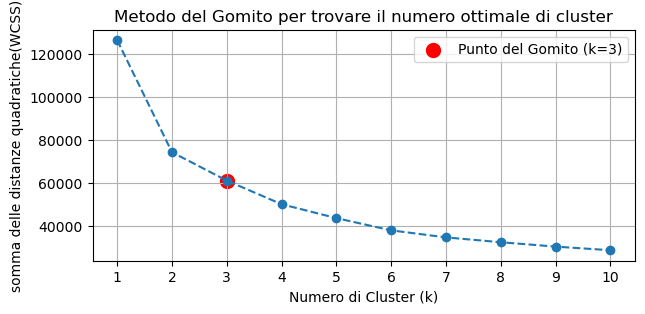

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# caricamento del dataset per il k-means standardizzato
dfPreStand = pd.read_csv('datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv')

# features usate per il clustering
featuresTocluster = ['matches', 'play_time', 'assists', 'kd_ratio', 'assists', 'headshots',
                        'score', 'missed_shots', 'hits_shots', 'suicides']
X = dfPreStand[featuresTocluster]

# vettore delle somme delle distanze quadratiche(inertia) per k che varierà nel range
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia è il valore del WCSS per k
    
    
# Traccia il grafico della regola del gomito
plt.figure(figsize=(7, 3))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('somma delle distanze quadratiche(WCSS)')
plt.title('Metodo del Gomito per trovare il numero ottimale di cluster')
plt.xticks(k_range)  # Visualizza ogni valore di k sull'asse x
plt.grid(True)

# punto del gomito su k=3
plt.scatter(3, wcss[2], s=100, c='red', label='Punto del Gomito (k=3)')
plt.legend()
plt.show()

Come si può notare dopo *k=3* l'inertia diminuisce in modo meno significativo, per cui il *valore naturale*, ovvero il miglior valore è *k=4*.

## 3.1) Assegnazione degli esempi alle classi
A questo punto trovato k, si proce con l'esecuzione del k-means con *k=4*(cluster) e si assegnano le classi agli esempi del dataset.

In [49]:
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10)
kmeans.fit(X)


# aggiunta delle label risultanti(classi) ai dataset preprocessati
dfStandClustered = pd.read_csv('datasets/unsupervised_learning_datasets/df_standardized_preprocessed.csv')
dfClustered = pd.read_csv('datasets/df_preprocessed.csv')


# aggiunta label classe giocatore ai due dataset
dfStandClustered['cluster_label'] = kmeans.labels_
dfClustered['cluster_label'] = kmeans.labels_


# salvataggio del dataset con label sulla classe(clustering) del giocatore
file_path = 'datasets/player_class_datasets/df_stand_preproc_class_lab.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfStandClustered.to_csv(file_path, index=False)

file_path = 'datasets/player_class_datasets/df_preproc_class_lab.csv'
if os.path.exists(file_path):
    os.remove(file_path)
dfClustered.to_csv(file_path, index=False)

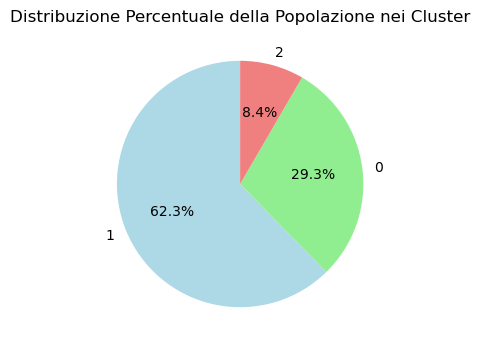

In [50]:

# Grafico a torta per mostrare la distribuzione della popolazione nei cluster
plt.figure(figsize=(4, 4))

# Conta il numero di punti in ciascun cluster
cluster_counts = dfClustered['cluster_label'].value_counts()

# Grafico a torta per mostrare la distribuzione della popolazione nei cluster
cluster_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.ylabel('')
plt.title('Distribuzione Percentuale della Popolazione nei Cluster')
plt.show()

# 4) Constrained Optimization Problem <a class="anchor" id="4"></a>

L'idea iniziale è quella di rappresentare il problema dell'assegnazione delle risorse tramite uno spazio di ricerca, in cui un algoritmo cercherà le soluzioni(assegnazioni su variabili) rispettando hard constraint e seguendo i soft constraint. 

La scelta dell'algoritmo con cui risolvere il problema è stata guidata dalle seguenti considerazioni: 

- Ci sono alcuni vincoli che devono essere inviolabili tramite **Hard Constraints**, come la capacità massima di giocatori in una partita
- L'algoritmo deve gestire uno scenario in cui le risorse sono limitate(partite istanziabili), consentendo il fatto che alcuni giocatori potrebbero non riuscire ad essere assegnati ad alcuna partita ovvero che i vincoli vengano soddisfati solo parzialmente. Questo potremmo codificarlo tramite **Soft Constraints**, vogliamo creare diverse penalità in base al soft constraint violato.
- L'algoritmo deve cercare la soluzione ottimale soddisfando quanti più soft constraints(di cui ognuno avrà una certa importanza), consentendo la violazione dei soft constraint ma massimizzando l'ottimalità della soluzione

Queste considerazioni non descrivono altro che un **Problema Di Ottimizzazione Vincolato**. In cui il problema viene rappresentato come uno spazio di assegnazioni possibili sulle variabili tramite **Hard Constraints**, riducendo i mondi possibili. La ricerca di una soluzione ottimale al problema viene guidata codificando una **Funzione Obiettivo** o **Soft Constraints**. Una soluzione ottimale sarà la migliore soluzione che soddisfa tutti i criteri definiti(soft constraints - funzione obiettivo). Nel nostro caso non vogliamo una semplice soluzione, ovvero giocatori assegnati per partite che non superino la capacità massima(hard constraint), ma vogliamo la migliore soluzione rispetto a criteri che verranno definiti successivamente in questo documento.

## 4.1)  Google OR-Tools <a class="anchor" id="4.1"></a>
Per il tipo di problema *Problema di Ottimizzazione Vincolato* scelto la libreria [Google OR-Tools](https://developers.google.com/optimization?hl=it). Una libreria open source che consente di risolvere in modo efficiente problemi di ottimizzazione vincolata in presenza di variabili intere, usando la *constraint programming*. Nel problema specifico affrontato i domini delle variabili sono interi e finiti, quindi dovrei ottenere prestazioni migliori. La libreria permette di gestire aspetti riguardanti:

- **Supporto per CSP**: OR-Tools è pensata per risolvere constraint satisfaction problems, usando un constraint solver 
- **Gestione di Constraint**: consentendo sia vincoli hard(vincoli hard saranno usati per gestire la capacità massima delle partite)
- **Funzione Obiettivo**: La funzione obiettivo ci permette di definire cosa rende una soluzione migliore delle altre. I soft constraint saranno codificati in termine di sommatorie di penalità da minimizzate all'interno della funzione obiettivo. Queste penalità vengono costruite in termini delle variabili del CSP. La definizione della *Funzione Obiettivo* da minizzare che muova il problema nella direzione desiderata è un aspetto molto comune in questo tipo di problemi. La progettazione della funzione obiettivo è anche l'aspetto che richiede più sforzi nella sua definizione, ovvero di comprendere come ottenere le soluzioni ottimali desiderate, in termini di penalità che compongono la funzione obiettivo(da minimizzare o massimizzare).
- **Efficienza**: La libreria è molto efficiente. CP-SAT non valuta tutte le soluzioni, utilizza tecniche avanzate per fare deduzioni e potare lo spazio di ricerca

La libreria non implementa tecniche di ricerca locale, ma riconduce un problema ad un sat problem, risolvendolo sistematicamente e applicando pruning o tecniche di branch and bound.

In [51]:
#Installazione Google OR-Tools
!pip install ortools;

In [52]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import numpy as np
import time

# inizializzazione modello
model = cp_model.CpModel()

## 4.2) Configurazione scenario <a class="anchor" id="4.2"></a>
Si costruiscono i due tipi di scenari di sotto carico e sovraccarico da simulare

In [53]:
# simulazione scenario di sotto carico
'''
AVAILABLE_PLAYERS = 203  # giocatori disponibili
AVAILABLE_MATCHES_INSTANTIABLE = 40  # istanze partite disponibili ad essere avviate
PLAYER_CAPACITY_MATCHES = 8  # capacità partite
PLAYERS_CLASS_COUNT = 3  # numero di cluster/classi giocatori
'''

# configurazione prova di sotto carico
AVAILABLE_PLAYERS = 68  # giocatori disponibili
AVAILABLE_MATCHES_INSTANTIABLE = 13  # istanze partite disponibili ad essere avviate
PLAYER_CAPACITY_MATCHES = 8  # capacità partite
PLAYERS_CLASS_COUNT = k  # costante numero di cluster/classi giocatori

#### Campione giocatori per lo scenario
Per lo scenario simulato vengono selezionati dei campioni casuali di giocatori dal dataset, la numerosità dipenderà dallo scenario simulato

In [54]:
# Selezione campione casuale di giocatori(seed fisso) dal dataset dfClustered
dfSampleOfPlayers = dfClustered.sample(n=AVAILABLE_PLAYERS, random_state=42)

## 4.3) Codifica Variabili <a class="anchor" id="4.3"></a>

### Problema della sommatoria di variabili con dominio non binario nella definizione di un vincolo rigido(#Sommatoria Condizionale#)
Nell'utilizzo di Google OR-Tools è stato riscontrato un limite (giustificato). Nel primo tentativo, durante la progettazione del CSP(variabili e hard constraints da inserire), come scelta progettuale si assumeva che ogni variabile del giocatere $P_i$(giocatore i-esimo) avrebbe rappresentato la partita a cui sarebbe appartenuto. Il cui dominio:

$$
P_i \quad \text{con} \quad \text{dom}(P_i) = \{ \text{numero di server istanziati} \}
$$

Una volta definite le variabili, per evitare che alle partite fossero assegnati più giocatori della loro capacità massima, l'intenzione era quella di creare un vincolo rigido per ogni partita $M_j$ che controllasse che la somma dei giocatori assegnati a una partita non superasse la capacità massima, ovvero:

$$
\left( \sum_{\substack{P_i \in \text{players} \\ \land \\ P_i = j}} 1 \right) \leq \text{playerCapacityMatches}
$$

dove `players` è il vettore dei giocatori, `j` è l'indice del match(tra i match istanziati), e `playerCapacityMatches` è la capacità massima delle partite.

### Sommatoria condizionale
Questa operazione è chiamata **sommatoria condizionale** e con Google OR-Tools non è possibile costruire vincoli di sommatorie che coinvolgono variabili con domini di numeri interi. Teoricamente, per verificare un vincolo con una sommatoria condizionale, il solver dovrebbe cercare tutte le possibili assegnazioni delle variabili coinvolte nella sommatoria condizionale affinché la condizione sia soddisfatta. In teoria, si potrebbe provare tutte le possibili assegnazioni di tutte le variabili affinchè che la sommatoria condizionale sia rispettata, ma la numerosità dei domini delle variabili(potenzialmente infiniti) renderebbe la complessità del problema estremamente elevata. Anche se dal punto di vista teorico sarebbe possibile trovare un'assegnazione che soddisfi una sommatoria condizionale, la complessità in presenza di variabili con domini ampi renderebbe questa ricerca molto più difficile. Per questo motivo, l'algoritmo della libreria Google OR-Tools non consente di costruire vincoli con sommatorie condizionali in presenza di variabili con domini su più valori.

<img src="doc_images/NonBooleanVariableError.png" alt="Testo Alternativo" style="width: 100%; height: auto;">

### Soluzione
Consultando la documentazione e vari esempi, ho constatato che è possibile utilizzare sommatorie condizionali nei vincoli solo se le variabili coinvolte sono **binarie**. In questo caso, la ricerca di un'assegnazione per variabili binarie non ancora assegnate che rispettino la sommatoria condizionale risulta più semplice rispetto alle variabili con domini interi. Il dominio più piccolo delle variabili binarie rende più fattibile la ricerca dell'assegnzione. Ovviamente, se il numero di variabili binarie diventa troppo elevato, il problema persisterà.


### Strategia Soluzione
La strategia iniziale adottata per costruire il CSP era quella di creare una variabile $P_i$ per ogni giocatore, il cui valore avrebbe rappresentato l'indice della partita a cui appartiene.

Questa problematica ha portato a riprogettare la struttura delle variabili nel CSP, in cui ogni variabile viene rappresentata tramite **variabili indicatrici** rispetto al dominio della variabile di partenza. Ad esempio:
Se una variabile $Y$ ha un dominio composto da 4 elementi, allora creo 4 variabili indicatrici $(Y_1, Y_2, Y_3, Y_4)$, l'assegnazione di una di queste variabili rappresenterà l'assegnazione su $Y$. Altro dettaglio è che con l'introduzione delle variabili binarie, è necessario costruire un vincolo che garantisca che "solo una di queste variabili può assumere valore 1". Questo può essere rappresentato con una sommatoria condizionale sulle variabili binarie:

$$
\sum_{Y_i \in Y} Y_i \leq 1
$$

A questo è possibile costruire un vincolo di sommatoria condizionale sulle variabili binarie, più complesso da gestire ma permette di codificare il vincolo che in precedenza non era possibile esprimere, risolvendo il problema di partenza.

### Variabili giocatori
Rispetto alle problematiche e alle considerazioni precedenti, la variabile che rappresenta l'appartenenza del giocatore sarà definita come un vettore di variabili binarie il cui numero di variabili è pari al dominio della variabile codificata di partenza. La variabile che assumerà il valore 1 indicherà l'indice del server di appartenenza per il giocatore. Quindi definisco i giocatori come vettori di variabili indicatrici:

In [55]:
# definizione dei player in termini di un vettore di variabile booleane
playersVars = []
# per ogni giocatore
for p in range(AVAILABLE_PLAYERS):
    # la variabile all'interno del vettore match con valore 1 indicherà il match di appartenenza del giocatore
    belongingToMatch = []
    # creazione di varibile booleane tanti quanti sono i match 
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
        belongingToMatch.append(
            model.NewBoolVar(f'player_{p}_in_match_{m}')
        )
    playersVars.append(belongingToMatch)

**Nota**: Bisogna ancora codificare un vincolo aggiuntivo che garantisca che solo una variabile tra quelle binarie, può essere avvalorata(un giocatore può appartenere ad una sola istanza di partita alla volta).

### Costanti classi(cluster) di appartenenza dei giocatori
Le classi dei giocatori vengono utilizzate nella costruzione della funzione obiettivo da minimizzare con l'obiettivo di usare questa informazione per comporre le soluzioni desiderate, in particolare vogliamo creare partite la cui classe dovrà essere quanto più possibile la medesima per ogni partita. Queste non devono mutare durante la ricerca della soluzione, quindi definite come costanti.

In [56]:
playerClassesConsts = [] #ogni posizione indica la classe d'appartenenza del giocatore i-esimo
for p in range(AVAILABLE_PLAYERS):
    player_class = dfSampleOfPlayers.iloc[p]['cluster_label']
    # Inserisci ogni classe come costante nel modello
    playerClassesConsts.append(player_class)

## 4.4) Hard constraint <a class="anchor" id="4.4"></a>
Con gli HC si definiscono dei vincoli che informano il solver su quali sono le assegnazioni sulle variabili da scartare.

#### HC appartenenza partita
Per codificare l'appartenenza di un giocatore ad una partita tramite variabili binarie, bisogna introdurre un vincolo per ogni giocatore che controlla che questo appartenga al massimo ad una partita, ovvero che solo una delle variabili binarie $P_{ij}$, fissato $i$, può assumere valore pari a $1$. Questo constraint controlla che la sommatoria dei valori sulle variabili binarie su una riga siano $< 1$. Viene quindi definito un vincolo per ogni giocatore o riga(le righe rappresentano le variabili binarie di appartenenza alle partite del giocatore)

$$
\sum_{j \in \text{matches}} P_{ij} \leq 1, \quad \forall i \in \text{players}
$$

Se la somma delle variabili binarie sarà zero allora i giocatori non apparterranno ad alcuna partita (questo sarà frequente nella situazione di sovraccarico). I giocatori che non trovano spazio in alcuna partita restano inassegnati. 

In [57]:
# per ogni giocatore p si definisce un vincolo con somma condizionale sulle variabili binarie del giocatore p 
for p in range(AVAILABLE_PLAYERS):
    model.Add( 
        sum(playersVars[p][m] for m in range(AVAILABLE_MATCHES_INSTANTIABLE)) <= 1
    )

#### HC Capacità massima partita
Risolto il problema sulla sommatoria condizionale adesso è possibile codificare il vincolo per cui ogni partita non può ospitare più giocatori della sua capacità massima. Questo viene fatto controllando che sommatoria dei valori delle signole variabili binarie di ogni giocatore appartenenti alla colonna non sia maggiore della capacità massima. Viene quindi definito un vincolo per ogni match o colonna(le colonne rappresentano i giocatori appartenenti alla partita).

$$
\sum_{i \in \text{players}} X_{ij} \leq \text{playerCapacityMatches}, \quad \forall j \in \text{matches}
$$

In [58]:
# vincolo: il numero di giocatori per partita non deve superare la capacità massima
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    model.Add(
        sum(playersVars[p][m] for p in range(AVAILABLE_PLAYERS)) <= PLAYER_CAPACITY_MATCHES
    )

## 4.5) Funzione Obiettivo - Soft Constraints <a class="anchor" id="4.5"></a>
Dal punto di vista teorico a differenza degli *hard Constraint*, i *soft Constraints* sono vincoli che possono essere violati, questi sono usati come criteri di preferenza sulle possibili assegnazioni ammissibili. Il **solver** generalmente deve trovare la migliore assegnazione totale seguendo queste preferenze, ovvero deve soddisfare i soft constraint nel miglior modo possibile, cercando la soluzione ottimale. Nei *problemi di ottimizzazione vincolata* i *soft Constraints* vengono spesso integrati all'interno della **funzione obiettivo** come somme di penalità o costi. L'obiettivo del problema diventa quindi trovare assegnazioni che minimizzino la funzione obiettivo(**criterio di ottimalità**). 

**Esempio:** Se si vogliono penalizzare assegnazioni sulle variabili che tendono a non assegnare una partita ad ogni giocatore, si può codificare una penalità rispetto a ogni posto vuoto nelle partite. Questa penalità viene inserita come termine della funzione obiettivo che dovrà essere minimizzata per guidare il solver nello stabilire la soluzione ottimale.

### 4.5.1) Suddivisione del problema in due istanze <a class="anchor" id="4.5.1"></a>
Una problematica che potrebbe affliggere i problemi di ottimizzazione vincolata è quella per cui in presenza di una funzione obiettivo troppo complessa o di numerosi hard constraints il problema potrebbe risultare difficile da gestire, con la possibilità di definire erroneamente constraint contraddittori, ottenendo risultati insoddisfacenti. Essendo il problema scomponibile in due istanze differenti(fase sotto carico e fase sovraccarico), una strategia intrapresa è stata quella di creare due funzioni obiettivo differenti per gestire le due istanze. 


#### Funzione Obiettivo sotto carico
La prima funzione obiettivo deve gestire il caso in cui la disponibilità di posti assegnabili è sufficiente rispetto alle domande di partecipazione dei giocatori. La funzione obiettivo deve guidare il solver nella ricerca di soluzioni che riempiano completamente le partite, in modo da guadagnare quante più partite istanziabili per le iterazioni successive.

**Esempio** Se posso istanziare un certo numero di partite e queste sono sufficienti per ospitare i giocatori in attesa, per garantire massima disponibilità in termini di partite, i giocatori devono distribuirsi riempiendo le partite il più possibile. Questo permette di guadagnre istanze di partite disponibili per le richieste successive. Nelle due immagini sotto, a parità di giocatori e di risorse si possono notare le differenze nel loro sfruttamento:
<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; margin-right: 4%; width: 45%;">
        <img src="doc_images/wrong_player_distribution_in_match.png" alt="Immagine 1" style="width: 100%; height: auto;">
        <p>Figura 1: Distribuzione che non sfrutta le risorse in modo ottimale, istanziare più partite limita la possibilità di ospitare le partite future</p>
    </div>
    <div style="text-align: center; width: 52%;">
        <img src="doc_images/correct_player_distribution_in_match.png" alt="Immagine 2" style="width: 100%; height: auto;">
        <p>Figura 2: Questa distribuzione sfrutta le risorse in modo ottimale, rendendo possibile l'avvio di partite future a parità di risorse.</p>
    </div>
</div>

Il secondo obiettivo è quello di mettere insieme i giocatori della stessa classe(cluster), rendendo l'esperienza ai giocatori meno frustrante, aumentando la loro permanenza sul servizio.
#### Funzione obiettivo sovraccarico
La seconda funzione obiettivo dovrà gestire il caso in cui la disponibilità delle risorse(partite) non è sufficiente per ospitare tutti i giocatori, per cui molti di loro non saranno assegnati ad una partita. La soluzione dell'istanza del problema dovrà riempire tutte le risorse, ma si specializzerà  sulla selezione dei giocatori da assegnare alle partite, codificando i seguenti aspetti:
- Giocatori con basso quitting rate
- Giocatori in attesa da più tempo
- Proporzione classi partite simile a quella della popolazione
- Giocatori nelle partite devono essere della stessa classe


### 4.5.2) Costruzione termini penalità funzione obiettivo_1 - istanza di sotto carico <a class="anchor" id="4.5.2"></a>
La libreria di OR-Tools accetta la codifica della funzione obiettivo solo in formato di funzione lineare, tutte le operazioni che introducono non linearità sono escluse. È stato complicato progettare tutti i termini di penalità(soft constraint) in termini lineari. Inoltre non è possibile costruire vincoli complessi o composti usando connettivi logici(and or not) o condizioni diverse da `==`, `<`, `>`, per cui alcune condizioni binarie sono state rappresentatae tramite "implicazioni logiche" sulle variabili ausiliarie, riadattando spesso il problema, introducendo e sfruttando ulteriori variabili ausiliarie.

I soft constraints sono codificati in termini di penalità per la funzione obiettivo nell'istanza di sotto carico sono:
### Massimizzare riempimento partite e giocatori assegnati
Nel caso si fosse potuta adottare la non linearità questo obiettivo si sarebbe potuto codificare come la minimizzazione di questa quantità per ogni partita:

$$
(\text{capienza_giocatori_partita} - \text{#giocatori_nella_partita}(P_i))^2
$$

andando a penalizzare di più le partite vuote e via via meno quelle piene. Questo avrebbe permesso di codificare con un colpo più aspetti, ma questo non è possibile a causa dell'obbligo di codificare la funzione obiettivo in termini lineari. 
Per codificare la stessa semantica del vincolo non lineare è stata adottata una strategia codificando 3 vincoli che insieme garantiscono lo stesso risultato: 

- Assegnare quanti più giocatori a una partita => minimizzare i giocatori non assegnati ad una partita.
- Riempire il più possibile le partite => minimizzare le partite non piene.
- Istanziare meno partite possibili => minimizzare il numero di partite istanziate

Di seguito l'implementazione

1. **Minimizzare i giocatori non assegnati ad una partita:** Il primo soft constraint ha l'obiettivo di ridurre al minimo il numero di giocatori non assegnati a ciascuna partita. Per ogni partita, costruiamo un termine da minimizzare che rappresenta i posti vuoti: `PLAYER_CAPACITY_MATCHES - playersInMatch[m]`. La variabile `playersInMatch[m]` è una variabile ausiliaria che tiene conto del numero di giocatori assegnati alla partita `m`-esima. Questa variabile è collegata alle variabili binarie `playersVars[p][m]`, che indicano se il giocatore `p` è stato assegnato alla partita `m`. Il vincolo rigido `model.Add(playersInMatch[m] == sum(playersVars[p][m] for p in range(AVAILABLE_PLAYERS)))` garantisce che il valore di `playersInMatch[m]` sia uguale alla somma delle variabili binarie, assicurando quindi che la variabile ausiliaria rifletta il numero effettivo di giocatori assegnati.

**Nota:** Per costruire termini complessi da minimizzare nella funzione obiettivo, è spesso necessario usare variabili ausiliarie collegate ad altre variabili tramite vincoli rigidi. Questo approccio è fondamentale perché la funzione obiettivo può essere espressa solo tramite operazioni elementari sulle variabili del CSP. Ad esempio, non è possibile scrivere direttamente:

```
penalty_players_not_assigned_to_match = [
    (PLAYER_CAPACITY_MATCHES - sum(playersVars[p][m] 
    for p in range(AVAILABLE_PLAYERS)))
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE)
]
```

Questo termine deve essere ridefinito utilizzando variabili intermedie.
**Nota:** Per evitare ridondanze nella documentazione, d'ora in verranno descritte solo le intuizioni e le motivazioni dietro le decisioni relative alle variabili ausiliarie introdotte, poiché il problema diventa progressivamente più complesso man mano che si esprimono vincoli con semantiche più articolate.

In [59]:
# SOFT CONSTRAINT GIOCATORI NON ASSEGNATI

# variabili ausiliarie per contare il numero di giocatori assegnati a ciascuna partita
playersInMatch = [
    model.NewIntVar(0, AVAILABLE_PLAYERS, f'players_in_match_{m}')
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE)
]

# collegare le variabili booleane alle variabili ausiliarie per il conteggio dei giocatori
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    model.Add(playersInMatch[m] == sum(playersVars[p][m] for p in range(AVAILABLE_PLAYERS)))

# penalità di giocatori non assegnati(posti vuoti nelle partite)
penalty_players_not_assigned_to_match = [
    (PLAYER_CAPACITY_MATCHES - playersInMatch[m])
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE)]

2) **Minimizzare le partite non piene:** Il secondo soft constraint ha l'obiettivo di minimizzare il numero di partite che non sono state riempite di giocatori, premiando quelle che lo sono. Per farlo, viene introdotta una variabile binaria ausiliaria `fullMatchesVars[m]` che indica se una partita è piena. Il valore di `fullMatchesVars[m]` è determinato da una condizione logica(implicazione) `OnlyEnforceIf` che verifica se il numero di giocatori presenti nella partita è massimo o meno.

In [60]:
# SOFT CONSTRAINT MINIMIZZARE IL NUMERO DI PARTITE CHE NON SONO PIENE

# Definizione delle variabili ausiliarie per indicare se una partita è piena
fullMatchesVars = [
    model.NewBoolVar(f'full_match_{m}') for m in range(AVAILABLE_MATCHES_INSTANTIABLE)
]

# Vincolo che collega la variabile booleana fullmatch al numero di giocatori nella partita
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    # Se il numero di giocatori nella partita `m` è uguale alla capacità massima, allora la partita è piena
    model.Add(playersInMatch[m] == PLAYER_CAPACITY_MATCHES).OnlyEnforceIf(fullMatchesVars[m])
    # Se il numero di giocatori nella partita `m` è inferiore alla capacità massima, la partita non è piena
    model.Add(playersInMatch[m] < PLAYER_CAPACITY_MATCHES).OnlyEnforceIf(fullMatchesVars[m].Not())

# Penalità per partite non piene
penalty_not_full_match = [
    fullMatchesVars[m].Not() for m in range(AVAILABLE_MATCHES_INSTANTIABLE)
]

3) **Minimizzare il numero di partite istanziate:** Questo termine di penalità crea una penalità per ogni partita istanziata (contenente almeno un giocatore). Il solver dovrà premiare soluzioni in cui ci sono meno partite istanziate. 

In [61]:
# SOFT CONSTRAINT MINIMIZZARE QUANTITÀ PARTITE ISTANZIATE 
# il vincolo penalizza la soluzione se sono state usate meno partite possibili

matchesInstantiatedVars = [
    model.NewBoolVar(f'instantiated_match_{m}') for m in range(AVAILABLE_MATCHES_INSTANTIABLE)
]

# Vincolo che collega la variabile booleana al numero di giocatori nella partita m
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    # se c'è' sono almeno 1 giocatore assegnato alla partita `m`, allora la partita è istanziata
    model.Add(playersInMatch[m] > 0).OnlyEnforceIf(matchesInstantiatedVars[m])
    # Se non ci sono giocatori assegnati, la partita non è istanziata
    model.Add(playersInMatch[m] == 0).OnlyEnforceIf(matchesInstantiatedVars[m].Not())

# Penalità per ogni partita istanziata
penalty_matches_instaced = [
    matchesInstantiatedVars[m] for m in range(AVAILABLE_MATCHES_INSTANTIABLE)
]

La codifica dei 3 soft constraints in termini di penalità da minimizzare nella funzone obiettivo ci permette di ottenere la categoria di soluzioni presenti in **Figura 2**. Quindi sono stati soddisfatti i primi due punti definiti nella sezione **1.3.1) Obiettivi scenario sotto carico**

### Comporre partite con giocatori della stessa classe
Dovranno essere preferite soluzioni per cui i giocatori appartenenti a una certa partita devono essere della stessa classe, evitando soluzioni in cui le classi di giocatori all'interno delle partite differiscono tra loro. Ovvero non vogliamo che succeda questo:

<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; width: 100%;">
        <img src="doc_images/wrong_class_distribution.png" alt="Immagine 1" style="width: 100%; height: auto;">
    </div>
</div>
Come si può notare, nella stessa partita ci sono giocatori di classi diverse, ma rispetto a quello che è stato stabilito negli *obiettivi del problema*, l'intento è quello di costruire partite i cui giocatori che vi partecipano abbiano classi omogenee.

Costruire la strategia per codificare la soluzione è stato parecchio più complesso del punto precedente. La strategia è stata quella di sfruttare la stessa intuizione usata nella *Massimizzazione del riempimento delle partite e giocatori assegnati*, che si basa su 3 criteri: 
- Penalizzare le soluzioni che non assegnano quanti più giocatori ad una partita(minimizzare giocatori non assegnati ad una partita)
- Penalizzare soluzioni che non riempiono le partite completamente(minimizzare le partite non piene)
- Penalizzare le soluzioni che istanziano troppe partite(minimizzare il numero di partite istanziate)

La strategia utilizzata per costruire partite omogenee si articola in due punti:

- Penalizzare le soluzioni che contengono partite in cui i giocatori di una certa classe assegnati non raggiungono la capacità massima della partita (minimizzare il numero di partite non riempite da giocatori di un'unica classe).
- Penalizzare le partite che ospitano più classi. La varietà delle classi deve tendere a 1(minimizzare le partite che hanno un numero alto di varietà di classi di giocatori).

Per ottenere le variabili ausiliarie necessarie per implementare queste due strategie, sono state definite variabili ausiliarie intermedie e vincoli rigidi (hard constraint) che garantiscono la consistenza durante il processo di risoluzione. Le variabili ausiliarie necessarie per determinare le quantità da minimizzare nella funzione obiettivo sono:
 - Una vettore di variabili per ciascuna partita che indica la quantità di giocatori di ciascuna classe per ciascuna partita
 - Un vettore di variabili binarie che indica la presenza delle classi in ciascuna partita

La costruzione di queste variabili non è stata banale, la loro definizione è stata più complessa rispetto al semplice conteggio dei giocatori totali per partita del punto precedente. Questo perchè bisogna considerare sia l'assegnazione del giocatore alla partita che la sua appartenenza a una classe specifica. Per facilitare la gestione della rappresentazione in variabili sono stati adottati vettori multidimensionali di variabili ausiliarie, garantendo la loro consistenza attraverso dei vincoli su ognuna delle variabili. È stato un processo complicato, ma questo ha permesso di esprimere i termini della funzione obiettivo da minimizzare per risolvere il problema con successo.

1) **Minimizzazione delle Partite Non Riempite da Giocatori di una Classe**: Per raggiungere questo obiettivo, è stata adottata una strategia in più fasi:

    1. **Creazione di Variabili Ausiliarie**: Inizialmente vengono create variabili booleane ausiliarie (`playerIsInClassInMatch`) per tenere traccia della classe di appartenenza di ogni giocatore all'interno di ciascun match. Queste variabili sono collegate alle altre variabili del modello tramite vincoli rigidi (hard constraint), per garantire la consistenza con le assegnazioni dei giocatori alle partite.

    2. **Variabili Ausiliarie Conteggio Giocatori per Classe e Partita**: Si definiscono variabili intere (`playersOfClassInMatch[m][c]`) per rappresentare il numero di giocatori di ogni classe assegnati a ogni partita. Queste variabili sono collegate alle variabili booleane precedentemente definite tramite vincoli che ne garantiscono la consistenza. In questo modo si assicura che il conteggio dei giocatori per ogni classe in ogni partita sia corretto.

    3. **Partite Piene per Classe**: Vengono poi create variabili booleane (`fullMatchOfClass[m][c]`) per indicare se una partita è piena di giocatori appartenenti a una certa classe. Queste variabili sono anch'esse collegate tramite vincoli rigidi che verificano se il numero di giocatori di una certa classe è pari alla capacità massima della partita (`PLAYER_CAPACITY_MATCHES`). Se la partita è piena, la variabile corrispondente sarà impostata su "vero".

    4. **Definizione della Penalità**: La penalità è costruita sommando tutte le variabili che indicano partite non completamente riempite da giocatori di una certa classe (`penalty_not_full_match_of_class`). Minimizzare questa quantità comporta ottenere soluzioni in cui le partite tendono a essere riempite completamente da giocatori della stessa classe, promuovendo partite omogenee e piene.

In [62]:
#################################################################################################
# VARIABILI AUSILIARIE E HARD CONSTRAINT per definire termine penalità
#################################################################################################
 
# 1) Creazione delle variabili booleane ausiliarie
playerIsInClassInMatch = [[[model.NewBoolVar(f'player_{p}_class_{c}_in_match_{m}')
                            for m in range(AVAILABLE_MATCHES_INSTANTIABLE)]
                           for c in range(PLAYERS_CLASS_COUNT)]
                          for p in range(AVAILABLE_PLAYERS)]


# 1) Definizione degli hard constraint(consistenza) per le variabili ausiliarie 
for p in range(AVAILABLE_PLAYERS):
    c = int(playerClassesConsts[p])
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
        model.Add(playerIsInClassInMatch[p][c][m] == playersVars[p][m])
        # impostiamo le variabili ausiliarie per le altre classi a 0
        for c_other in range(PLAYERS_CLASS_COUNT):
            if c_other != c:
                model.Add(playerIsInClassInMatch[p][c_other][m] == 0)


# 2) Variabili ausiliarie per contare il numero di giocatori di ogni classe in ogni match
playersOfClassInMatch = []
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    playersOfClass = []
    for c in range(PLAYERS_CLASS_COUNT):
        playersOfClass.append(
            model.NewIntVar(0, AVAILABLE_PLAYERS, f'players_of_class{c}_in_match_{m}')
        )
    playersOfClassInMatch.append(playersOfClass)

    
# 2) Vincoli per contare il numero di giocatori di ogni classe in ogni match
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    for c in range(PLAYERS_CLASS_COUNT):
        model.Add(playersOfClassInMatch[m][c] == sum(playerIsInClassInMatch[p][c][m] for p in range(AVAILABLE_PLAYERS)))


# 3) Definizione delle variabili ausiliarie per indicare se una partita è piena di giocatori
# di una certa classe con rispettivi hard constraint(consistenza)
fullMatchOfClass = []
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    fullMatchesVars = []
    for c in range(PLAYERS_CLASS_COUNT):
        # Creiamo una variabile booleana per indicare se la partita m è piena per la classe c
        fullMatchVar = model.NewBoolVar(f'full_match_{m}_of_class_{c}')
        fullMatchesVars.append(fullMatchVar)
        
        # Vincolo: Se il numero di giocatori della classe c nella partita m è uguale alla capacità massima, allora la partita è piena per quella classe
        model.Add(playersOfClassInMatch[m][c] == PLAYER_CAPACITY_MATCHES).OnlyEnforceIf(fullMatchVar)
        # Altrimenti, se è inferiore, la partita non è piena per quella classe
        model.Add(playersOfClassInMatch[m][c] < PLAYER_CAPACITY_MATCHES).OnlyEnforceIf(fullMatchVar.Not())
    fullMatchOfClass.append(fullMatchesVars)

In [63]:
#################################################################################################
# PENALITÀ:
#################################################################################################
    
# 4) Definizione delle penalità per le partite non piene per classe
penalty_not_full_match_of_class = []
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    for c in range(PLAYERS_CLASS_COUNT):
        # La penalità è 1 se la partita m non è piena per la classe c
        penalty = fullMatchOfClass[m][c].Not()
        penalty_not_full_match_of_class.append(penalty)

2) **Minimizzare le partite che hanno un numero alto di varietà di classi di giocatori:** Questa parte del codice ha l'obiettivo di ridurre la presenza di partite con una varietà alta di numero di classi di giocatori, garantendo una maggiore omogeneità tra i partecipanti. Per ottenere questo risultato, vengono create variabili ausiliarie e vincoli rigidi che misurano la varietà di classi per ciascuna partita. La strategia si articola in più passaggi:

    1) **Creazione delle Variabili di Presenza: ** Per ogni classe e per ogni partita, vengono definite variabili booleane (`presenceOfClassInMatch[m][c]`) che indicano se almeno un giocatore della classe `c` è presente nella partita `m`. I vincoli per le variabili di presenza vengono definiti in modo tale da garantire che la variabile `presenceOfClassInMatch[m][c]` sia correttamente impostata a seconda delle assegnazioni dei giocatori:
        1) Se non ci sono giocatori della classe `c` nel sistema, il valore della variabile `presenceOfClassInMatch[m][c]` viene fissato a 0.
        2) Se invece esistono giocatori della classe `c`, viene utilizzato un vincolo di uguaglianza massima (`AddMaxEquality`) per collegare la variabile di presenza alle variabili di assegnazione dei giocatori (`playersVars[p][m]`). In questo modo, la variabile di presenza viene impostata a 1 se almeno un giocatore della classe `c` è assegnato alla partita `m`.

    3) **Definizione della Penalità:** Per incentivare la formazione di partite con una minore varietà di classi, viene definita una penalità che tiene conto del numero di classi presenti in ciascuna partita:
        1) Viene calcolata la somma delle variabili di presenza (`presenceOfClassInMatch[m][c]`) per ciascuna partita `m`, ottenendo un valore che rappresenta il numero di classi diverse presenti in quella partita.
        2) La penalità (`penalty_multiple_classes_in_match`) viene costruita sommando i valori delle variabili di presenza per tutte le partite e per tutte le classi. Minimizzare questa penalità significa ridurre il numero di classi diverse presenti in ciascuna partita, favorendo la creazione di partite con giocatori della stessa classe.
        
Questa strategia permette di ridurre la varietà di classi di giocatori nelle partite, migliorando l'omogeneità tra i giocatori.

In [64]:
#################################################################################################
# VARIABILI AUSILIARIE E HARD CONSTRAINT per definire termine penalità
#################################################################################################

# 1) creazione delle variabili di presenza per ogni classe in ogni partita
presenceOfClassInMatch = []
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    presenceOfClass = []
    for c in range(PLAYERS_CLASS_COUNT):
        presence_var = model.NewBoolVar(f'presence_of_class{c}_in_match_{m}')
        presenceOfClass.append(presence_var)
    presenceOfClassInMatch.append(presenceOfClass)

# 2) Definizione dei vincoli per le variabili di presenza
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    for c in range(PLAYERS_CLASS_COUNT):
        # Lista dei giocatori della classe c
        players_of_class_c = [p for p in range(AVAILABLE_PLAYERS) if int(playerClassesConsts[p]) == c]
        
        if len(players_of_class_c) == 0:
            # 2.1) Non ci sono giocatori di questa classe
            model.Add(presenceOfClassInMatch[m][c] == 0)
        else:
            # 2.2) Vincolo che collega la presenza con le assegnazioni dei giocatori
            model.AddMaxEquality(presenceOfClassInMatch[m][c], [playersVars[p][m] for p in players_of_class_c])

In [65]:
#################################################################################################
# PENALITÀ 
#################################################################################################

# 3) Definizione delle penalità basata sul contare la presenza di giocatori di varie classi in una partita
penalty_multiple_classes_in_match = []
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    penalty_multiple_classes_in_match.append(
        sum(presenceOfClassInMatch[m][c] for c in range(PLAYERS_CLASS_COUNT))
    )

Abilitando via via le penalità codificate tramite funzione obiettivo, e analizziamo i risultati:

#### 1) Nessuna penalità attiva sull'omogeneità delle classi dei giocatori all'interno delle partite
Senza alcuna penalità relativa all'omogeneità le partite che si vengono a configurare nella soluzione ottimale contengono classi diverse di giocatori. Tutti i giocatori vengono assegnati ad una partita. Questa erano le soluzioni ottimali di partenza.
<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; width: 100%;">
        <img src="doc_images/non_homogeneous_classes.png" style="width: 100%; height: auto;">
    </div>
</div>


#### 2) Penalità sulle partite non riempite interamente da giocatori della stessa classe
Applicando la prima penalità sulle partite non riempite interamente da giocatori della stessa classe, si nota che: tutte i giocatori trovano posta in una partita, le partite sono per la maggioranza costituite da giocatori della stessa classe. Il problema di applicare solo questo vincolo è che si viene a creare spesso una partita non piena in cui ci sono giocatori di varie classi.
<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; width: 100%;">
        <img src="doc_images/homogeneous_classes_1.png" style="width: 100%; height: auto;">
    </div>
</div>

#### 3) Penalità sulle partite che contengono più classi di giocatori
Applicando anche la seconda penalità, che penalizza ulteriormente le partite con giocatori di classi differenti, si osserva che il solver, per ottenere una soluzione ottimale, preferisce scartare il giocatore di classe 0 dalla partita 12, non assegnandolo ad alcuna partita. Nonostante sia presente una penalità per i giocatori non assegnati ad una partita, il costo di avere giocatori di classi differenti in una partita, soprattutto quando la loro presenza è inferiore alla capacità massima, risulta più elevato. Di conseguenza il solver preferisce la soluzione in cui il giocatre non viene assegnato a nessuna partita. Questo dovrà attendere una nuova iterazione dell'algoritmo con altri giocatori prima di poter essere assegnato.

<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; width: 100%;">
        <img src="doc_images/homogeneous_classes_2.png" style="width: 100%; height: auto;">
    </div>
</div>

Possiamo quindi essere soddisfatti dei risultati e possiamo dire che tutti gli obiettivi definiti nella sezione *1.3.1) Obiettivi scenario sotto carico* sono stati raggiunti se non migliorati.

### 4.5.3) Esecuzione dello scenario di sotto carico <a class="anchor" id="4.5.3"></a>
I `lambda_penality_i` sono fattori che regolano l'intensità delle penalità permettendo di dare più importanza ad alcune soluzioni rispetto che ad altre, **azzerando i lambda è possibile disattivare le penalità**. 

All'interno di `model.Minimize(*)` si inseriscono i fattori della funzione obiettivo da minimizzare per valutare l'ottimalità della soluzione. 

In [66]:
lambda_penalty_1 = 1 # fattore/peso giocatori non assegnati
lambda_penalty_2 = 1 # fattore/peso partite non completamente piene
lambda_penalty_3 = 1 # fattore/peso quantità partite istanziate
lambda_penalty_4 = 1 # Peso per la penalità di partite non riempite totalmente da una specifica classe
lambda_penalty_5 = 1 # Peso per la presenza di più classi di giocatori nella partita

# minimizzare la penalità totale
model.Minimize(
    lambda_penalty_1 * sum(penalty_players_not_assigned_to_match) + 
    lambda_penalty_2 * sum(penalty_not_full_match) + 
    lambda_penalty_3 * sum(penalty_matches_instaced) +
    lambda_penalty_4 * sum(penalty_not_full_match_of_class) + 
    lambda_penalty_5 * sum(penalty_multiple_classes_in_match)
)


solver = cp_model.CpSolver() # inizializzazione solver
solver.parameters.max_time_in_seconds = 120.0  # limite di tempo di 120 secondi
status = solver.Solve(model) # avvio del solver


Popolazione del campione di partenza:
Classe 0: 16 giocatori
Classe 1: 49 giocatori
Classe 2: 3 giocatori
----------------------------------------------------------
Soluzione trovata:
Giocatori non assegnati a nessuna partita: 1 - [4]


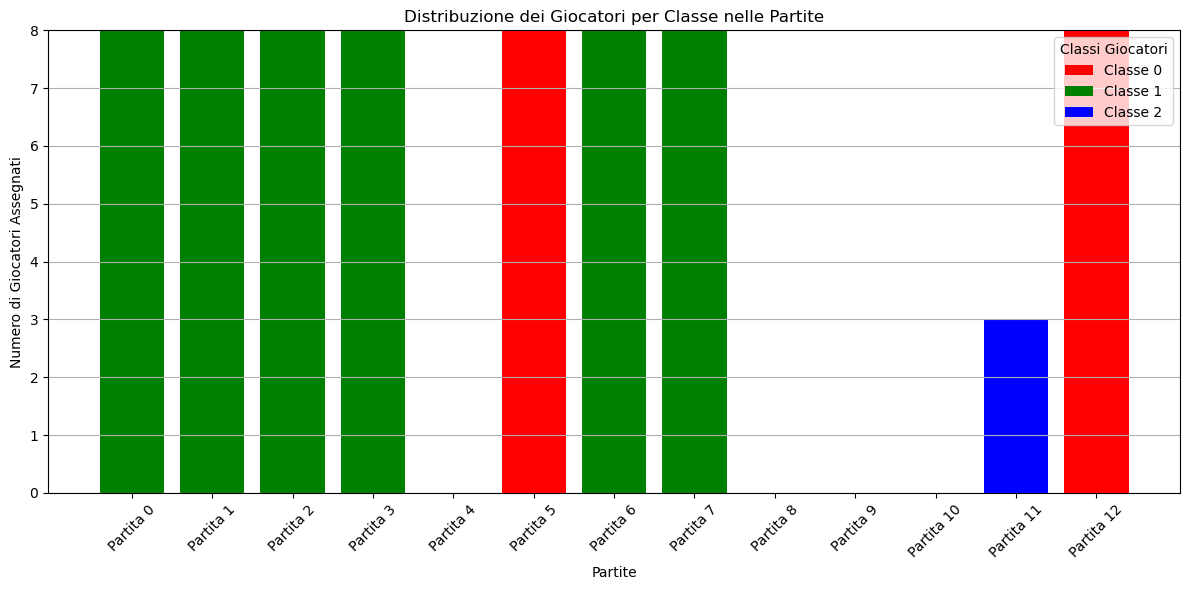

In [67]:
# Conteggio dei giocatori per classe nel campione iniziale
player_classes = dfSampleOfPlayers['cluster_label'].astype(int)
class_counts = player_classes.value_counts().sort_index()

print("Popolazione del campione di partenza:")
for c in range(PLAYERS_CLASS_COUNT):
    count = class_counts.get(c, 0)
    print(f"Classe {c}: {count} giocatori")

# Definizione delle costanti per le classi di ciascun giocatore
playerClassesConsts = [int(class_label) for class_label in dfSampleOfPlayers['cluster_label']]


print('----------------------------------------------------------')
# Output della soluzione finale
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print('Soluzione trovata:')
    
    unassigned_players = []
    assigned_players = []
    assignments = [[] for _ in range(AVAILABLE_MATCHES_INSTANTIABLE)]
    match_classes = []

    # Conta il numero di giocatori per classe in ciascuna partita
    players_per_class_per_match = [[0] * PLAYERS_CLASS_COUNT for _ in range(AVAILABLE_MATCHES_INSTANTIABLE)]
    
    for p in range(AVAILABLE_PLAYERS):
        assigned = False
        for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
            if solver.Value(playersVars[p][m]) == 1:
                assigned_players.append(p)
                assignments[m].append(p)
                assigned = True
                # Assicurati che l'indice sia un intero
                players_per_class_per_match[m][int(playerClassesConsts[p])] += 1
                break
        if not assigned:
            unassigned_players.append(p)

    print(f'Giocatori non assegnati a nessuna partita: {len(unassigned_players)} - {unassigned_players}')

    # Colori per le classi
    class_colors = ['red', 'green', 'blue']

    # Creazione del grafico a barre impilate
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = [f'Partita {m}' for m in range(AVAILABLE_MATCHES_INSTANTIABLE)]
    x = np.arange(len(labels))

    # Costruzione delle barre impilate
    bottom = np.zeros(len(labels))
    for c in range(PLAYERS_CLASS_COUNT):
        counts = [players_per_class_per_match[m][c] for m in range(AVAILABLE_MATCHES_INSTANTIABLE)]
        ax.bar(x, counts, bottom=bottom, color=class_colors[c], label=f'Classe {c}')
        bottom += np.array(counts)

    # Aggiunta delle etichette e del titolo
    ax.set_xlabel('Partite')
    ax.set_ylabel('Numero di Giocatori Assegnati')
    ax.set_title('Distribuzione dei Giocatori per Classe nelle Partite')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend(title='Classi Giocatori')
    ax.grid(axis='y')

    plt.tight_layout()
    plt.show()
    
    # DEBUG - presenza e conteggio dei giocatori per ogni partita
    '''
    print("(DEBUG) Valori delle classi per ogni partita:")
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
        # Costruisci la stringa delle presenze delle classi per la partita m
        presenze = []
        for c in range(PLAYERS_CLASS_COUNT):
            # Ottieni il valore della presenza dal solver
            presenza = solver.Value(presenceOfClassInMatch[m][c])
            presenza_str = f"{c}: {'true' if presenza else 'false'}"
            presenze.append(presenza_str)
        # Combina le presenze in una stringa
        presenze_str = "| ".join(presenze)
        # Stampa la riga della partita con le presenze tra parentesi
        print(f"Partita {m} (Presenza Classe; {presenze_str}):")
        # Ora stampa il conteggio dei giocatori per classe
        for c in range(PLAYERS_CLASS_COUNT):
            num_players = solver.Value(playersOfClassInMatch[m][c])
            print(f"  Classe {c}: {num_players} giocatori")
        '''
else:
    print('Nessuna soluzione ottimale trovata')


### 4.5.4) Costruzione termini penalità funzione obiettivo_2 - istanza di sovraccarico <a class="anchor" id="4.5.4"></a>
Lo scenario configurato è quello di sovraccarico. In questo scenario si ricostruiscono le stesse variabili(comprese quelle ausiliarie e hard constraints) sui giocatori(appartentenza match), capienza massima, variabili sulle di classi giocatori, e la penalità che permette di assegnare giocatori alle partite.

**Nota:** Il dataset usato non mi ha fornito alcun dato sui tempi di attesa medi dei giocatori, per cui essendo un toy problem, ho deciso di generare dei dati simulati sui tempi d'attesa del giocatore. Ho utilizzato una distribuzione normale per generare i dati, supponendo abbia `media = 11` e `deviazione standard = 2`. Con una distribuzione normale i tempi di attesa tendono a essere distribuiti attorno a un valore medio, con alcuni giocatori che aspettano meno e altri che aspettano di più, quindi abbastanza realistico come dato. Il valore sul tempo di attesa è una variabile indipendente rispetto al resto delle features, per cui è concesso generare i valori.

In [68]:
# generazione dei dati per la features wait_time
mean_wait_time = 11  # in minuti
std_dev = 5
generatedDf = dfClustered
generatedDf['wait_time'] = np.abs(np.random.normal(mean_wait_time, std_dev, len(df))).astype(int)

file_path = 'datasets/search_dataset/df_generated.csv'
if os.path.exists(file_path):
    os.remove(file_path)
    
generatedDf.to_csv(file_path, index=False)

In [69]:
# simulazione scenario di sovraccarico
'''
AVAILABLE_PLAYERS = 426  # giocatori disponibili
AVAILABLE_MATCHES_INSTANTIABLE = 40  # istanze partite disponibili ad essere avviate
PLAYER_CAPACITY_MATCHES = 8  # capacità partite
PLAYERS_CLASS_COUNT = 3  # numero di cluster/classi giocatori
'''

# configurazione prova di sovraccarico
AVAILABLE_PLAYERS = 266  # giocatori disponibili
AVAILABLE_MATCHES_INSTANTIABLE = 13  # istanze partite disponibili ad essere avviate
PLAYER_CAPACITY_MATCHES = 8  # capacità partite
PLAYERS_CLASS_COUNT = k  # costante numero di cluster/classi giocatori

# Ricostruzione del campione casuale di giocatori(seed fisso) dal dataset dfClustered
dfSampleOfPlayers = generatedDf.sample(n=AVAILABLE_PLAYERS, random_state=42)

# inizializzazione modello
model = cp_model.CpModel()

In [70]:
# definizione dei player in termini di un vettore di variabile booleane
playersVars = []
# per ogni giocatore
for p in range(AVAILABLE_PLAYERS):
    # la variabile all'interno del vettore match con valore 1 indicherà il match di appartenenza del giocatore
    belongingToMatch = []
    # creazione di varibile booleane tanti quanti sono i match 
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
        belongingToMatch.append(
            model.NewBoolVar(f'player_{p}_in_match_{m}')
        )
    playersVars.append(belongingToMatch)
    
    
# per ogni giocatore p si definisce un vincolo con somma condizionale sulle variabili binarie del giocatore p 
for p in range(AVAILABLE_PLAYERS):
    model.Add( 
        sum(playersVars[p][m] for m in range(AVAILABLE_MATCHES_INSTANTIABLE)) <= 1
    )
    
    
# vincolo: il numero di giocatori per partita non deve superare la capacità massima
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    model.Add(
        sum(playersVars[p][m] for p in range(AVAILABLE_PLAYERS)) <= PLAYER_CAPACITY_MATCHES
    )
    

# costanti sulle classi dei giocatori
playerClassesConsts = [] #ogni posizione indica la classe d'appartenenza del giocatore i-esimo
for p in range(AVAILABLE_PLAYERS):
    player_class = dfSampleOfPlayers.iloc[p]['cluster_label']
    # Inserisci ogni classe come costante nel modello
    playerClassesConsts.append(player_class)
    

# SOFT CONSTRAINT GIOCATORI NON ASSEGNATI
# variabili ausiliarie per contare il numero di giocatori assegnati a ciascuna partita
playersInMatch = [
    model.NewIntVar(0, AVAILABLE_PLAYERS, f'players_in_match_{m}')
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE)
]

# collegare le variabili booleane alle variabili ausiliarie per il conteggio dei giocatori
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    model.Add(playersInMatch[m] == sum(playersVars[p][m] for p in range(AVAILABLE_PLAYERS)))

# penalità di giocatori non assegnati(posti vuoti nelle partite)
penalty_players_not_assigned_to_match = [
    (PLAYER_CAPACITY_MATCHES - playersInMatch[m])
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE)]

Vengono definite delle variabili per ogni partita, in cui ognuna rappresenta la classe di giocatori che essa deve ospitare. Tutti i giocatori che vengono assegnati dovranno usare questa informazione per distribuirsi nelle partite della stessa classe. Queste variabili saranno inoltre utilizzate per garantire che la proporzione numerica delle partite di una certa classe converga alla proporzione delle classi nel campione di giocatori che simula lo scenario di sovraccarico.
Anche questa variabile sarà definita in termini di variabili binarie, per consentire sommatorie condizionali nella fase di definizione dei vincoli. 

In [71]:
# definizione dei match in termini di un vettore di variabili booleane, l'assegnazione sul match indica la classe di appartenenza
matchesVars = []

for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    # la variabile all'interno del vettore match con valore 1 indicherà la classe di giocatori ammessi
    playerClass = []
    # creazione di varibile booleane tante quante sono le classi 
    for c in range(PLAYERS_CLASS_COUNT):
        playerClass.append(
            model.NewBoolVar(f'match_{m}_class_{c}')
        )
    matchesVars.append(playerClass)

Anche qui per codificare la classe scelta per la partita tramite variabili binarie, si introduce un vincolo per ogni partita che garantisce che una partita possa essere in relazione con una sola classe

In [72]:
# si definisce un vincolo per ogni match p
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    model.Add(
        sum(matchesVars[m][c] for c in range(PLAYERS_CLASS_COUNT)) <= 1
    )

### Differenza tra proporzioni(classi partite e classi campione)
L'obiettivo è far sì che la proporzione delle partite istanziate per ospitare giocatori di una determinata classe tenda a riflettere la proporzione della classe sul campione dei giocatori in cerca di una partita. Per raggiungere questo obiettivo, viene minimizzata la differenza tra la proporzione delle partite per classe e la proporzione dei giocatori della stessa classe sul campione.

$$
\lambda_i \sum_{i} \left| \frac{\sum_{\text{class}(M_j) = C_i} 1}{|M|} - \frac{\sum_{\text{class}(P_k) = C_i} 1}{|P|} \right|
$$

Dove: 
- $M_j$: Rappresenta la j-esima partita istanziata
- $\text{class}(M_j)$: È una funzione che restituisce la classe della partita
- $|M|$: È il numero totale delle partite istanziate
- $M_j$: Rappresenta il k-esimo giocatore del campione
- $\text{class}(M_j)$: È una funzione che restituisce la classe del giocatore
- $|P|$: È il numero totale di giocatori nel campione


Tuttavia, poiché le variabili nel modello sono limitate a valori interi o binari, la proporzione deve essere gestita in modo da evitare calcoli con numeri reali. Per far fronte a questo problema, viene utilizzato un fattore di scala (`scale_factor`) per convertire le proporzioni in valori interi, facilitando così il loro utilizzo nelle espressioni lineari.

1) **Calcolo della Proporzione dei Giocatori per Classe:** Il primo passo consiste nel calcolare la proporzione di giocatori appartenenti a ogni classe rispetto al totale all'interno del campione. Questa proporzione viene poi scalata utilizzando il fattore `scale_factor = 100`, in modo da poter rappresentare la proporzione come un valore intero, dato che il modello è in grado di lavorare con numeri interi: 

In [73]:
scale_factor = 100

# proporzione di giocatori di una certa classe rispetto al campione, scalata a valori interi
averagePlayers = []
for c in range(PLAYERS_CLASS_COUNT):
    class_players = dfSampleOfPlayers[dfSampleOfPlayers['cluster_label'] == c]
    proportion = (class_players.shape[0] / AVAILABLE_PLAYERS) * scale_factor
    averagePlayers.append(int(proportion))

2) **Definizione delle Variabili per il Numero di Partite per Classe:** Vengono create le variabili (`matchesPerClass[c]`) per rappresentare il numero di partite istanziate per ogni classe. Queste variabili sono collegate tramite hard constraint al numero di partite istanziate per ciascuna classe `c`. In questo modo potremo usare, matchesPerClass[c](partite sono dedicate ai giocatori di classe c) per ottenere il termine della proporzione da minimizzare.

In [74]:
# Definizione delle variabili per il numero di partite assegnate a ciascuna classe
matchesPerClass = [
    model.NewIntVar(0, AVAILABLE_MATCHES_INSTANTIABLE, f'matches_for_class_{c}')
    for c in range(PLAYERS_CLASS_COUNT)
]

# collega alla variabile matchesPerClass[c] il numero di partite di una certa classe, sommando
# la colonna(la colonna equivale alla classe)
for c in range(PLAYERS_CLASS_COUNT):
    model.Add(matchesPerClass[c] == sum(matchesVars[m][c] for m in range(AVAILABLE_MATCHES_INSTANTIABLE)))

3) **Calcolo della Distanza tra la Proporzione Desiderata e quella Effettiva:** Per garantire che la proporzione delle partite per classe tenda a quella dei giocatori per classe, viene introdotta una variabile (`distance`) che rappresenta la differenza tra le due proporzioni. Poiché la funzione valore assoluto non è una funzione lineare, viene utilizzato un escamotage per gestire il valore assoluto tramite due vincoli lineari: 

```
# 1) distance >= matchesPerClass[c] * scale_factor 
    - averagePlayers[c] * AVAILABLE_MATCHES_INSTANTIABLE
    
# 2) distance >= averagePlayers[c] * AVAILABLE_MATCHES_INSTANTIABLE 
    - matchesPerClass[c] * scale_factor
```

In questo modo, la variabile distance rappresenta sempre il valore assoluto della differenza tra la proporzione desiderata e quella effettiva.

4) **Penalità sulla distanza:** La penalità viene costruita utilizzando le variabili `distance`, rappresentando la distanza tra la distribuzione dei giocatori e quella delle partite. Minimizzare questa penalità aiuta ad ottenere una soluzione in cui la distribuzione delle partite riflette al meglio la distribuzione della popolazione dei giocatori in cerca di una partita.

In [75]:
### SOFT CONSTRAINT PROPORZIONE CLASSE DELLE PARTITE
   
# Definisci variabili per la distanza tra la proporzione desiderata e quella effettiva
penalty_proportion_distance_terms = []
for c in range(PLAYERS_CLASS_COUNT):
    distance = model.NewIntVar(0, scale_factor * AVAILABLE_MATCHES_INSTANTIABLE, f'distance_class_{c}')
    model.Add(distance >= matchesPerClass[c] * scale_factor - averagePlayers[c] * AVAILABLE_MATCHES_INSTANTIABLE)
    model.Add(distance >= averagePlayers[c] * AVAILABLE_MATCHES_INSTANTIABLE - matchesPerClass[c] * scale_factor)
    penalty_proportion_distance_terms.append(distance)

Come si può vedere dalle figure, minimizzando il termine di penalità sulle differenze tra proporzioni, cosente al solver di restituire come soluzioni ottimali, quelle dove le proporzioni delle classi di giocatori del campione sono quanto più vicine alle proporzioni delle partite istanziate di una certa classe: 

<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; margin-right: 4%; width: 50%;">
        <img src="doc_images/pop_proportion.png" alt="Immagine 1" style="width: 100%; height: auto;">
        <p>Figura 3: Distribuzione delle classi nel campione di partenza</p>
    </div>
    <div style="text-align: center; width: 50%;">
        <img src="doc_images/match proportion.png" alt="Immagine 2" style="width: 100%; height: auto;">
        <p>Figura 4: Distribuzione delle partite associate ad una classe</p>
    </div>
</div>

Con questa altra visualizzazione si può vedere come il constraint si riflette sulla classe delle partite istanziate. Nell'immagine i bollini del colore della classe indicano la specifica classe di giocatori che la partita dovrà ospitare.
<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; width: 100%;">
        <img src="doc_images/match_proportion.png" style="width: 100%; height: auto;">
    </div>
</div>
Questo risultato ci da la base per poter configurare le partite affinchè i giocatori che verranno assegnati rispecchino la distribuzione del campione in termini di proporzioni.

### Partite con giocatori della stessa classe
L'obiettivo di questo soft contraint è garantire che i giocatori assegnati alle partite appartengano preferibilmente alla stessa classe assegnata alla partita. In questo modo, si favorisce anche l'omogeneità delle partite, in cui i giocatori della stessa classe vengono raggruppati insieme. Inoltre, la distribuzione delle classi di giocatori assegnati alle partite tenderà a rispecchiare la distribuzione del campione di giocatori. 

Come si può vedere, attualmente la situazione iniziale dal punto dei giocatori assegnati alle partite, non riflette affatto la proporzione delle classi presenti nel campione. I giocatori sono assegnati indipendentemente dalla classe della partita.
<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; width: 100%;">
        <img src="doc_images/wrong_match_belonging.png" style="width: 100%; height: auto;">
    </div>
</div>

*Per ottenere la informazioni grafiche sulla composizione delle partite(classi giocatori), si riutilizzano porzioni di codice già definite nella sezione precedente, introducendo delle variabili da cui poter ricavare le informazioni usate per la visualizzazione dei risultati.*

In [76]:
#################################################################################################
# VARIABILI AUSILIARIE E HARD CONSTRAINT per ottenere info sulla visualizzazione
#################################################################################################
 
# 1) Creazione delle variabili booleane ausiliarie
playerIsInClassInMatch = [[[model.NewBoolVar(f'player_{p}_class_{c}_in_match_{m}')
                            for m in range(AVAILABLE_MATCHES_INSTANTIABLE)]
                           for c in range(PLAYERS_CLASS_COUNT)]
                          for p in range(AVAILABLE_PLAYERS)]


# 1) Definizione degli hard constraint(consistenza) per le variabili ausiliarie 
for p in range(AVAILABLE_PLAYERS):
    c = int(playerClassesConsts[p])
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
        model.Add(playerIsInClassInMatch[p][c][m] == playersVars[p][m])
        # impostiamo le variabili ausiliarie per le altre classi a 0
        for c_other in range(PLAYERS_CLASS_COUNT):
            if c_other != c:
                model.Add(playerIsInClassInMatch[p][c_other][m] == 0)


# 2) Variabili ausiliarie per contare il numero di giocatori di ogni classe in ogni match
playersOfClassInMatch = []
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    playersOfClass = []
    for c in range(PLAYERS_CLASS_COUNT):
        playersOfClass.append(
            model.NewIntVar(0, AVAILABLE_PLAYERS, f'players_of_class{c}_in_match_{m}')
        )
    playersOfClassInMatch.append(playersOfClass)

    
# 2) Vincoli per contare il numero di giocatori di ogni classe in ogni match
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    for c in range(PLAYERS_CLASS_COUNT):
        model.Add(playersOfClassInMatch[m][c] == sum(playerIsInClassInMatch[p][c][m] for p in range(AVAILABLE_PLAYERS)))


# 3) Definizione delle variabili ausiliarie per indicare se una partita è piena di giocatori
# di una certa classe con rispettivi hard constraint(consistenza)
fullMatchOfClass = []
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    fullMatchesVars = []
    for c in range(PLAYERS_CLASS_COUNT):
        # Creiamo una variabile booleana per indicare se la partita m è piena per la classe c
        fullMatchVar = model.NewBoolVar(f'full_match_{m}_of_class_{c}')
        fullMatchesVars.append(fullMatchVar)
        
        # Vincolo: Se il numero di giocatori della classe c nella partita m è uguale alla capacità massima, allora la partita è piena per quella classe
        model.Add(playersOfClassInMatch[m][c] == PLAYER_CAPACITY_MATCHES).OnlyEnforceIf(fullMatchVar)
        # Altrimenti, se è inferiore, la partita non è piena per quella classe
        model.Add(playersOfClassInMatch[m][c] < PLAYER_CAPACITY_MATCHES).OnlyEnforceIf(fullMatchVar.Not())
    fullMatchOfClass.append(fullMatchesVars)

Per codificare il vincolo andremo a minimizzare due quantità:
- Minimizzare di classi nelle diverse da quelle della partita

Si riutilizza il codice della sezione precedente per codificare i termini da minimizzare, questi si baseranno sulle stesse variabili già costruite nella sezione precedente: 

In [77]:
#################################################################################################
# VARIABILI AUSILIARIE E HARD CONSTRAINT per definire termine penalità
#################################################################################################

# 1) creazione delle variabili di presenza per ogni classe in ogni partita
presenceOfClassInMatch = []
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    presenceOfClass = []
    for c in range(PLAYERS_CLASS_COUNT):
        presence_var = model.NewBoolVar(f'presence_of_class{c}_in_match_{m}')
        presenceOfClass.append(presence_var)
    presenceOfClassInMatch.append(presenceOfClass)

# 2) Definizione dei vincoli per le variabili di presenza
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    for c in range(PLAYERS_CLASS_COUNT):
        # Lista dei giocatori della classe c
        players_of_class_c = [p for p in range(AVAILABLE_PLAYERS) if int(playerClassesConsts[p]) == c]
        
        if len(players_of_class_c) == 0:
            # 2.1) Non ci sono giocatori di questa classe
            model.Add(presenceOfClassInMatch[m][c] == 0)
        else:
            # 2.2) Vincolo che collega la presenza con le assegnazioni dei giocatori
            model.AddMaxEquality(presenceOfClassInMatch[m][c], [playersVars[p][m] for p in players_of_class_c])

1) **Minimizzare la Presenza di Giocatori di Classi Diverse dalla Classe della Partita:** Per ogni partita, viene calcolata una penalità ogni volta che sono presenti giocatori appartenenti a classi diverse da quella assegnata alla partita. La somma di tutte queste penalità costituirà il termine da minimizzare. Minimizzando questa penalità, le soluzioni più ottimali saranno quelle in cui i giocatori appartenenti a una classe diversa rispetto a quella della partita vengono progressivamente esclusi. 

In [78]:
# Definizione delle variabili di penalità
penalty_no_players_of_match_class = []
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    for c in range(PLAYERS_CLASS_COUNT):
        penalty_var = model.NewBoolVar(f'penalty_no_players_of_match_{m}_class_{c}')
        penalty_no_players_of_match_class.append(penalty_var)

        # Vincoli per collegare penalty_var all'ineguaglianza
        model.Add(matchesVars[m][c] != presenceOfClassInMatch[m][c]).OnlyEnforceIf(penalty_var)
        model.Add(matchesVars[m][c] == presenceOfClassInMatch[m][c]).OnlyEnforceIf(penalty_var.Not())



La codifica di questo vincolo rende ottimali tutte le soluzioni in cui la partita è popolata da tutti e soli i giocatori di classe uguale a quella della partita. In altre parole oltre che a comporre le partite di giocatori con la stessa classe della partita, questo vincolo permetterà di ottenere partite con composizione omogenea. 

<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; width: 100%;">
        <img src="doc_images/matches_proportionate_to_the_sample_and_homogeneous.png" style="width: 100%; height: auto;">
    </div>
</div>

Le partite continueranno a mantenere la proporzione delle classi di partite rispetto a quella del campione.

#### Partite con basso quitting rate
L'obiettivo è ridurre il tasso di abbandono dei giocatori assegnati a ciascuna partita, privilegiando i giocatori con un basso tasso di abbandono (quitting rate). Per raggiungere questo scopo, viene creato un termine che rappresenta la somma dei valori di `game_exits` di tutti i giocatori assegnati a una partita. Minimizzando questo termine, il solver tenderà a selezionare giocatori con un basso quitting rate, garantendo partite più stabili e riducendo la probabilità di abbandono.

In [79]:
# Costanti info game_exits giocatori
playerGameExitsConsts = []  # ogni posizione indica il numero di game_exits del giocatore i-esimo
for p in range(AVAILABLE_PLAYERS):
    player_exits = dfSampleOfPlayers.iloc[p]['game_exits']
    playerGameExitsConsts.append(int(player_exits))  # Assicurati che il valore sia intero

# Variabili ausiliarie per il calcolo dei game exits totali per ciascuna partita
game_exits_total_per_match_var = [
    model.NewIntVar(0, sum(playerGameExitsConsts), f'game_exits_total_match_{m}')
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE)
]

# Collegare le variabili game_exits alle partite in base ai giocatori assegnati
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    model.Add(
        game_exits_total_per_match_var[m] == sum(
            playerGameExitsConsts[p] * playersVars[p][m] for p in range(AVAILABLE_PLAYERS)
        )
    )


Uno dei problemi riscontrati è che utilizzando direttamente i valori dei "game exits" come penalità, il solver tendeva a preferire soluzioni in cui nessun giocatore veniva assegnato a una partita. Questo accadeva perché i fattori di penalità (`lambda_penalty_i`) avevano tutti lo stesso valore, e la penalità associata ai "game exits" risultava essere più alta rispetto agli altri vincoli. In altre parole, il solver preferiva evitare completamente la penalità sui "game exits" (quitting rate), anche se questo significava non assegnare alcun giocatore alle partite, ottenendo così soluzioni non soddisfacenti. Come si può notare il solver pur di ottenere una penalità nulla sugli exits, preferiva le partite svuotate
<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; width: 100%;">
        <img src="doc_images/empty_matches_to_reduce_exit_penalty.png" style="width: 100%; height: auto;">
    </div>
</div>

Per risolvere questo problema, sono stati aumentati di importanza tutti i vincoli(fattori/pesi) precedenti (`lambda_penalty_1 = 100`, `lambda_penalty_2 = 100`, `lambda_penalty_3 = 100`) ed è stato ridotto d'importanza il vincolo sui "game exits" (`lambda_penalty_4 = 0.1`). In questo modo, il solver darà maggiore priorità alle soluzioni che ci interessano(giocatori assegnati, classi partite, classi omogenee), e la minimizzazione del termine sul quitting rate non sarà così dominante da portare a valutare le partite vuote come ottimali, ma avrà il peso giusto per essere considerato senza dominare eccessivamente sul risultato finale.


<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; width: 100%;">
        <img src="doc_images/high_rate_quit.png" style="width: 100%; height: auto;">
    </div>
</div>
 ---
<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; width: 100%;">
        <img src="doc_images/low_rate_quit.png" style="width: 100%; height: auto;">
    </div>
</div>

Si può dire che la definizione del vincolo ha minimizzato al meglio il quitting rate di tutti i giocatori assegnati ad una partita, abbassando la media ed il totale tasso di quitting rate presente nelle partite. 

Questo permetterà di favorire giocatori che mantengono le partite piene, inducendo quindi il pieno utilizzo delle risorse server(giocatori che abbandonano facilmente una partita, potrebbero richiedere di partecipare a nuove istanze, saturando ulteriormente la richiesta e portando a non sfruttare pienamente le risorse). 

#### Tempo di attesa dei giocatori in coda

Per ridurre il rischio che i giocatori abbandonino il servizio a causa delle lunghe code, l'obiettivo di questo constraint è dare la precedenza ai giocatori in attesa da più tempo. Il sistema, oltre a considerare tutte le preferenze precedenti, favorirà l'assegnazione dei giocatori con maggiore tempo di attesa. Questo approccio aiuterà anche i giocatori con un quitting rate troppo alto, evitando che vadano in starvation. In altre parole, nonostante la penalizzazione per l'alto quitting rate, questi giocatori verranno comunque assegnati a una partita quando il loro tempo di attesa diventa sufficientemente alto.

Per implementare questo vincolo, si usa la stessa strategia usata per il quitting rate. Viene creato un termine che rappresenta la somma dei valori dei `wait_time` di tutti i giocatori assegnati a una partita. in questo caso però questo termine non sarà da minimizzare ma da massimizzare. Minimizzare il segno negativo del termine equivarrà a massimizzare i giocatori che hanno tempi di attesa più grandi


Quest'ultimo vincolo disincentivando l'abbandono del servizio da parte dell'utenza.

In [80]:
# Costanti info wait_time giocatori
playerWaitTimeConsts = []  # ogni posizione indica il tempo di attesa del giocatore i-esimo
for p in range(AVAILABLE_PLAYERS):
    player_wait_time = generatedDf.iloc[p]['wait_time']
    playerWaitTimeConsts.append(int(player_wait_time))  # Assicurati che il valore sia intero

# Variabili ausiliarie per il calcolo del tempo di attesa totale per ciascuna partita
wait_time_total_per_match_var = [
    model.NewIntVar(0, sum(playerWaitTimeConsts), f'wait_time_total_match_{m}')
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE)
]

# Collegare le variabili wait_time alle partite in base ai giocatori assegnati
for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
    model.Add(
        wait_time_total_per_match_var[m] == sum(
            playerWaitTimeConsts[p] * playersVars[p][m] for p in range(AVAILABLE_PLAYERS)
        )
    )

Per equilibrare l'ottimalità della soluzione, anche con questo soft contraint ho cercato empiricamente la configurazione del parametro `lambda_penalty_5` che andasse a migliorare le soluzioni dal punto di vista del maggiorare giocatori assegnati con attesa in coda più alta. Aumentare però va ad abbassare(poco) l'ottimalità dei giocatori con alto tasso di abbandono, quindi la scelta di `lambda_penalty_5` è dettata rispetto a quanto siamo disposti a peggiorare l'ottimalità sul tasso di abbandono. Possiamo quindi vedere come l'ottimalità della soluzione sia migliorata in termini di giocatori scelti con maggior tempo in coda: 

<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; margin-right: 1%; width: 50%;">
        <img src="doc_images/bad_wait_time_.png" alt="Immagine 1" style="width: 100%; height: auto;">
        <p>In assenza del vincolo la scelta dei giocatori per comporre partite è indipendente dal tempo che hanno trascorso in coda.</p>
    </div>
    <div style="text-align: center; width: 50%;">
        <img src="doc_images/good_wait_time_.png" alt="Immagine 2" style="width: 100%; height: auto;">
        <p>Abilitando il vincolo vengono preferiti i giocatori che attendono da più tempo, aumentando il tempo totale e il tempo medio in coda dei giocatori assegnati ad una partita. In altre parole sono stati serviti i giocatori in attesa da più tempo.</p>
    </div>
</div>
Come possiamo vedere introducendo la penalità sulla coda di attesa, l'ottimalità della soluzione rispetto al tasso di abbandono si è abbassata, ma complessivamente questo è sicuramente un risultato migliore rispetto alla non applicazione dei due vincoli:

<div style="display: flex; align-items: center; justify-content: center;">
    <div style="text-align: center; margin-right: 1%; width: 50%;">
        <img src="doc_images/worst_optimal_solution.png" alt="Immagine 1" style="width: 100%; height: auto;">
        <p>Vincoli rimossi</p>
    </div>
    <div style="text-align: center; width: 50%;">
        <img src="doc_images/good_wait_time_.png" alt="Immagine 2" style="width: 100%; height: auto;">
        <p>Vincoli entrambi presenti</p>
    </div>
</div>
Come possiamo vedere applicare i due vincoli, scegliendo il giusto valore per i pesi lamda, migliora complessivamente l'ottimalità della soluzione (ovvero la media dei `game exits` diminuisce, la media dei `wait time` aumenta)
- Dando priorità di assegnazione ad una partita ai giocatori con un basso tasso di abbandono (quitting rate)
- Dando priorità di assegnazione ad una partita ai giocatori che sono in attesa da più tempo.

### 4.5.5) Esecuzione dello scenario di sovraccarico <a class="anchor" id="4.5.5"></a>
I `lambda_penality_1`, `lambda_penality_2`, `lambda_penality_3`, possono essere visti a questo punto come vincoli "più hard" data la loro maggiore intensità, dando più importanza a soluzioni che rispettino i primi 3 punti.

All'interno di `model.Minimize(*)` si inseriscono i fattori della funzione obiettivo da minimizzare per valutare l'ottimalità della soluzione. 

**Nota:** azzerando i lambda è possibile disattivare le penalità.  

In [81]:
lambda_penalty_1 = 100 # fattore/peso giocatori non assegnati
lambda_penalty_2 = 100 # fattore/peso proporzione classi partite rispetto alla proporzione del campione 
lambda_penalty_3 = 100 # fattore/peso giocatori di classe diversa dalla partita
lambda_penalty_4 = 0.1 # fattore/peso sul termine quitting rate
lambda_penalty_5 = 1 # fattore/peso sul termine tempo di attesa

# minimizzare la penalità totale
model.Minimize(
    lambda_penalty_1 * sum(penalty_players_not_assigned_to_match) +
    lambda_penalty_2 * sum(penalty_proportion_distance_terms) + 
    lambda_penalty_3 * sum(penalty_no_players_of_match_class) +
    lambda_penalty_4 * sum(game_exits_total_per_match_var) + 
    lambda_penalty_5 * (-sum( wait_time_total_per_match_var))
)

# solver e risoluzione
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 120.0  # limite di tempo di 120 secondi
# risolvere il problema senza callback
status = solver.Solve(model)


Con l'ultimo vincolo, sono stati raggiunti tutti gli obiettivi della sezione **1.3.2) Obiettivi scenario sovraccarico**. Di seguito si possono visualizzare i risultati dell'esperimento.

Giocatori non assegnati a nessuna partita:
[0, 1, 5, 7, 8, 9, 10, 11, 14, 16, 19, 20, 21, 22, 26, 27, 28, 29, 30, 32, 33, 36, 38, 39, 41, 43, 45, 46, 48, 51, 52, 53, 55, 56, 58, 59, 60, 62, 63, 65, 66, 67, 69, 71, 72, 73, 75, 76, 78, 81, 83, 85, 87, 88, 89, 92, 93, 96, 97, 98, 100, 103, 105, 106, 108, 111, 112, 113, 116, 117, 123, 126, 128, 129, 130, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 146, 147, 148, 149, 150, 152, 153, 154, 155, 157, 158, 161, 162, 163, 165, 166, 168, 170, 171, 173, 174, 175, 176, 178, 179, 180, 181, 182, 184, 187, 188, 189, 191, 192, 195, 196, 198, 199, 200, 202, 204, 208, 210, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 224, 226, 232, 235, 237, 238, 240, 241, 242, 244, 245, 246, 248, 250, 254, 255, 256, 257, 259, 260, 261, 262, 265]


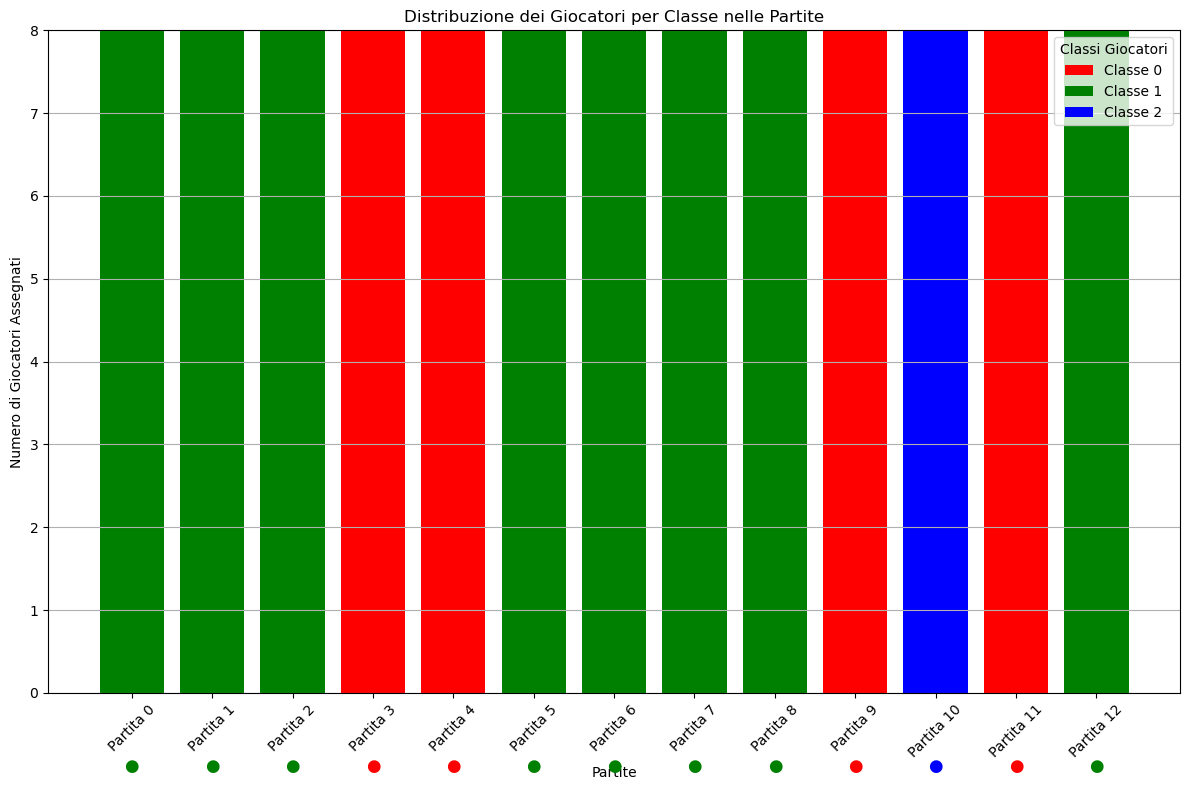

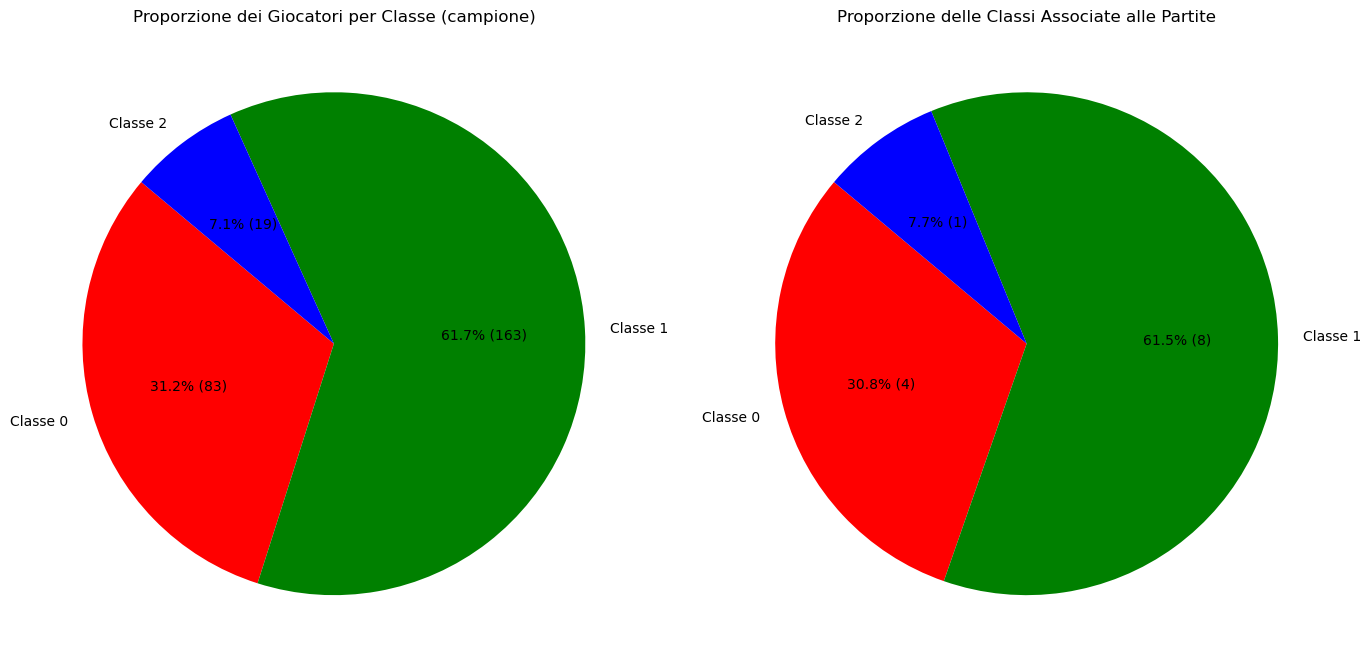

Totale game exits: 4429, Media game exits: 42.59
Totale wait time: 1554, Media wait time: 14.94


In [82]:
# Output della soluzione finale
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    unassigned_players = []
    assigned_players = []
    match_classes = []

    # Conta il numero di giocatori per classe in ciascuna partita
    players_per_class_per_match = [[solver.Value(playersOfClassInMatch[m][c]) for c in range(PLAYERS_CLASS_COUNT)]
                                   for m in range(AVAILABLE_MATCHES_INSTANTIABLE)]
    
    # Conta le classi assegnate a ciascuna partita
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
        for c in range(PLAYERS_CLASS_COUNT):
            if solver.Value(matchesVars[m][c]) == 1:
                match_classes.append(c)
                break
        else:
            match_classes.append(-1)  # Classe non assegnata
    
    # Calcolo delle statistiche di "game_exits" e "wait_time" per ogni partita
    game_exits_total_per_match = [0] * AVAILABLE_MATCHES_INSTANTIABLE
    game_exits_avg_per_match = [0] * AVAILABLE_MATCHES_INSTANTIABLE
    wait_time_total_per_match = [0] * AVAILABLE_MATCHES_INSTANTIABLE
    wait_time_avg_per_match = [0] * AVAILABLE_MATCHES_INSTANTIABLE
    players_in_match_details = [[] for _ in range(AVAILABLE_MATCHES_INSTANTIABLE)]

    for p in range(AVAILABLE_PLAYERS):
        assigned = False
        for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
            if solver.Value(playersVars[p][m]) == 1:
                assigned_players.append(p)
                assigned = True
                game_exits_total_per_match[m] += playerGameExitsConsts[p]
                wait_time_total_per_match[m] += playerWaitTimeConsts[p]
                players_in_match_details[m].append((p, playerGameExitsConsts[p], playerWaitTimeConsts[p]))
                break
        if not assigned:
            unassigned_players.append(p)

    for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
        num_players = sum(players_per_class_per_match[m])
        if num_players > 0:
            game_exits_avg_per_match[m] = game_exits_total_per_match[m] / num_players
            wait_time_avg_per_match[m] = wait_time_total_per_match[m] / num_players

    print(f'Giocatori non assegnati a nessuna partita:')
    print(unassigned_players)

    # Visualizzazione grafica dei giocatori assegnati e non assegnati con barre impilate per classi
    fig, ax = plt.subplots(figsize=(12, 8))
    labels = [f'Partita {m}' for m in range(AVAILABLE_MATCHES_INSTANTIABLE)]
    x = np.arange(len(labels))

    # Colori per le classi
    class_colors = ['red', 'green', 'blue']

    # Costruzione delle barre impilate
    bottom = np.zeros(len(labels))
    for c in range(PLAYERS_CLASS_COUNT):
        counts = [players_per_class_per_match[m][c] for m in range(AVAILABLE_MATCHES_INSTANTIABLE)]
        ax.bar(x, counts, bottom=bottom, color=class_colors[c], label=f'Classe {c}')
        bottom += np.array(counts)

    ax.set_xlabel('Partite')
    ax.set_ylabel('Numero di Giocatori Assegnati')
    ax.set_title('Distribuzione dei Giocatori per Classe nelle Partite')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend(title='Classi Giocatori')
    ax.grid(axis='y')

    # Aggiunta dei bollini colorati sotto al titolo della partita per indicare la classe assegnata
    for m, match_class in enumerate(match_classes):
        if match_class == 0:
            ax.text(x[m], -0.8, '●', color='red', fontsize=12, ha='center', va='top')
        elif match_class == 1:
            ax.text(x[m], -0.8, '●', color='green', fontsize=12, ha='center', va='top')
        elif match_class == 2:
            ax.text(x[m], -0.8, '●', color='blue', fontsize=12, ha='center', va='top')
        else:
            ax.text(x[m], -0.8, '●', color='gray', fontsize=12, ha='center', va='top')

    plt.tight_layout()
    plt.show()

    # Visualizzazione delle proporzioni delle classi con grafici a torta (campione e partite)
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    # Grafico a torta per la proporzione dei giocatori nel campione
    class_counts = [dfSampleOfPlayers[dfSampleOfPlayers['cluster_label'] == c].shape[0] for c in range(PLAYERS_CLASS_COUNT)]
    labels = [f'Classe {c}' for c in range(PLAYERS_CLASS_COUNT)]
    axs[0].pie(class_counts, labels=labels, colors=class_colors, autopct=lambda p: f'{p:.1f}% ({int(p * sum(class_counts) / 100)})', startangle=140)
    axs[0].set_title('Proporzione dei Giocatori per Classe (campione)')

    # Grafico a torta per la proporzione delle classi associate alle partite
    match_class_counts = [match_classes.count(c) for c in range(PLAYERS_CLASS_COUNT)]
    if sum(match_class_counts) > 0:  # Solo se ci sono partite assegnate a una classe
        axs[1].pie(match_class_counts, labels=labels, colors=class_colors, autopct=lambda p: f'{p:.1f}% ({int(p * sum(match_class_counts) / 100)})', startangle=140)
        axs[1].set_title('Proporzione delle Classi Associate alle Partite')
    else:
        axs[1].text(0.5, 0.5, 'Nessuna classe assegnata alle partite', ha='center', va='center')
        axs[1].set_title('Proporzione delle Classi Associate alle Partite')

    plt.tight_layout()
    plt.show()
    
    total_game_exits = sum(game_exits_total_per_match)
    avg_game_exits = total_game_exits / len(assigned_players) if len(assigned_players) > 0 else 0
    total_wait_time = sum(wait_time_total_per_match)
    avg_wait_time = total_wait_time / len(assigned_players) if len(assigned_players) > 0 else 0

    #print(f'Soluzione trovata:')
    print(f'Totale game exits: {total_game_exits}, Media game exits: {avg_game_exits:.2f}')
    print(f'Totale wait time: {total_wait_time}, Media wait time: {avg_wait_time:.2f}')
    
    # DEBUG player assegnati
    #for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
        #print(f'Partita {m}:')
        #print(f'  Giocatori assegnati: {sum(players_per_class_per_match[m])}', f'  Classe assegnata: {match_classes[m]}', f'  Classi presenti: {players_per_class_per_match[m]}')

        #print(f'  Tot. game exits: {game_exits_total_per_match[m]}, Avg. game exits: {game_exits_avg_per_match[m]:.2f}')
        #print(f'  Tot. wait time: {wait_time_total_per_match[m]}, Avg. wait time: {wait_time_avg_per_match[m]:.2f}')
        #print(f'  Giocatori e dettagli:')
        #for player, game_exits, wait_time in players_in_match_details[m]:
            #print(f'    Giocatore {player}: game exits = {game_exits}, wait time = {wait_time}')
else:
    print('Nessuna soluzione ottimale trovata')


### 4.6) Considerazioni finali <a class="anchor" id="4.6"></a>
Si può affermare che le due istanze del problema siano state rappresentate con successo mediante lo spazio delle assegnazioni. L'algoritmo di ottimizzazione vincolata, definito da hard constraint e una funzione obiettivo soft, permette di individuare le migliori soluzioni ottimali in grado di gestire al meglio i due scenari del toy problem. 


### 4.7) Prestazioni e ottimalità <a class="anchor" id="4.7"></a>
Nonostante Google OR-Tools utilizzi varie tecniche efficienti di ricerca(pruning), le prestazioni diventano scarse con l'aumentare delle variabili e con le grandezze dei domini, garantendo però la massima ottimalità della soluzione. Nel caso si dovessero gestire ordini di grandezza superiori in termini di giocatori e partite, lo spazio di ricerca potrebbe diventerebbe troppo vasto per strategie sistematiche come questa. Per ottenere migliori prestazioni a discapito dell'ottimalità, si potrebbe tentare di utilizzare algoritmi di ricerca locale stocastica come il Simulated Annealing, che insieme a strategie di random restart, potrebbe aiutare a ricavare un minimo locale abbastanza ottimale, in tempi molto più ragionevoli. 


**Nota:** L'interfaccia di Google OR-Tools è standard per cui si potrebbe switchare libreria passando a librerie commerciali o più performanti. 

## 5) Monitoraggio del Sistema con Prolog <a class="anchor" id="5"></a>
 
Per implementare il monitoraggio logico del sistema, ho utilizzato Prolog tramite la libreria `pyswip`. La Knowledge Base è costruita con due tipi di fatti e alcune regole di inferenza:

- **Fatto giocatore**: rappresenta le informazioni di un giocatore assegnato a una partita e include 4 parametri: 
  - ID del giocatore
  - ID della partita a cui è assegnato
  - Classe del giocatore
  - Tempo di attesa
  
  Esempio: `giocatore(g1, m1, 0, 15).`

- **Fatto partita**: rappresenta lo stato di una partita e include 4 parametri:
  - ID della partita
  - Numero di giocatori assegnati
  - Classe della partita
  
  Esempio: `partita(m1, 4, 0).`

### Regole Implementate

1. **Partita piena**:  Verifica se una partita ha raggiunto la capacità massima `partita_piena(PartitaID) :- partita(PartitaID, NumeroGiocatori, Classe, _), NumeroGiocatori >= CapacitaMassima.`

2. **Sistema pieno**: Determina se il sistema è vicino alla saturazione `sistema_pieno :- findall(PartitaID, partita_piena(PartitaID), ListaPartitePiene), length(ListaPartitePiene, NumeroPartitePiene), NumeroPartitePiene >= SogliaPiene.` 

3. **Partita non uniforme**: Identifica partite con giocatori di classi diverse `partita_non_uniforme(PartitaID) :- partita(PartitaID, _, Classe, _), giocatore(_, PartitaID, ClasseGiocatore, _, _), Classe \= ClasseGiocatore.`  
   

Funzione per creare dinamicamente la KB, e scrive tutto il contenuto nel file KB.pl, che può essere interrogato con Prolog.

In [83]:
# Funzione aggiornata per generare la knowledge base con documentazione semplificata e concisa

def crea_kb_da_csp(solver, playersVars, playerClassesConsts, playerWaitTimeConsts, match_classes, PLAYER_CAPACITY_MATCHES, AVAILABLE_PLAYERS, AVAILABLE_MATCHES_INSTANTIABLE):
    # Inizializza il contenuto della knowledge base con spiegazioni concise sui predicati
    kb_content = """
    % Knowledge Base per Monitoraggio del Sistema

    % Fatti
    % giocatore/4 - Rappresenta un giocatore assegnato a una partita
    % Parametri: ID del giocatore, ID della partita, Classe del giocatore, Tempo di attesa
    % Esempio: giocatore(g1, m1, 0, 15).
    
    % partita/3 - Rappresenta lo stato di una partita
    % Parametri: ID della partita, Numero di giocatori, Classe della partita
    % Esempio: partita(m1, 4, 0).
    """

    # Aggiunta dei fatti per i giocatori alla Knowledge Base
    for p in range(AVAILABLE_PLAYERS):
        for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
            if solver.Value(playersVars[p][m]) == 1:
                kb_content += f"giocatore(g{p}, m{m}, {int(playerClassesConsts[p])}, {playerWaitTimeConsts[p]}).\n"

    # Aggiunta dei fatti per le partite alla Knowledge Base
    for m in range(AVAILABLE_MATCHES_INSTANTIABLE):
        num_giocatori = sum(solver.Value(playersVars[p][m]) for p in range(AVAILABLE_PLAYERS))
        kb_content += f"partita(m{m}, {num_giocatori}, {int(match_classes[m])}).\n"

    # Aggiunta delle regole di monitoraggio alla KB
    kb_content += f"""
    % Regole

    % partita_piena/1 - Verifica se una partita ha raggiunto la capacità massima
    partita_piena(PartitaID) :- partita(PartitaID, NumeroGiocatori, Classe), NumeroGiocatori >= {PLAYER_CAPACITY_MATCHES}.

    % sistema_pieno/0 - Determina se il sistema è vicino alla saturazione
    sistema_pieno :- findall(PartitaID, partita_piena(PartitaID), ListaPartitePiene), 
                     length(ListaPartitePiene, NumeroPartitePiene), NumeroPartitePiene >= {AVAILABLE_MATCHES_INSTANTIABLE * 0.6}.

    % partita_non_uniforme/1 - Identifica partite con giocatori di classi diverse
    partita_non_uniforme(PartitaID) :-
        partita(PartitaID, _, Classe),
        giocatore(_, PartitaID, ClasseGiocatore, _),
        Classe \\= ClasseGiocatore.
    """

    # Scrivi la KB nel file kb.pl
    with open("kb.pl", "w") as file:
        file.write(kb_content)

    print("Knowledge Base (kb.pl) creata con successo.")


Note: nella regola sistema_pieno, NumeroPartitePiene >= NumeroPartitePiene >= {AVAILABLE_MATCHES_INSTANTIABLE * 0.6} è una soglia utilizzata per determinare quando il sistema è considerato "vicino alla saturazione" in base al numero di partite che sono piene.

In [84]:
# Parametri del CSP
available_players = len(playersVars)  # Numero di giocatori totali
available_matches = len(playersVars[0])  # Numero di partite disponibili
capacita_massima = max(sum(solver.Value(playersVars[p][m]) for p in range(available_players)) for m in range(available_matches))

# Chiamata alla funzione per creare la Knowledge Base
crea_kb_da_csp(
    solver,
    playersVars,
    playerClassesConsts,
    playerWaitTimeConsts,
    match_classes,
    capacita_massima,
    available_players,
    available_matches
)


Knowledge Base (kb.pl) creata con successo.


Non riuscendo ad integrare l'esecuzione di KB proposizionali su jupyter, ho semplicemente incollato la KB generata nel file `kb.pl` su https://swish.swi-prolog.org/ permettendomi di eseguire le query, come ad esempio:

1) **Ricavare le partite non uniformi e i giocatori coinvolti:** Questa query `partita_non_uniforme(PartitaID), giocatore(GiocatoreID, PartitaID, ClasseGiocatore, _).` trova tutte le partite in cui ci sono giocatori di classi diverse rispetto alla classe della partita. Questa elenca inoltre i giocatori che causano questa non uniformità. Questa query mi ha permesso effettivamente di ricavare le partite che contenessero giocatori di classi non uniformi. Restituisce false se tutte le partite sono "uniformi". 

2) **Trovare tutte le partite piene non uniformi:** La query `partita_piena(PartitaID), partita_non_uniforme(PartitaID).` è utile per identificare partite che hanno raggiunto la capacità massima e che contengono giocatori di classi miste, restituendo le partite.


Queste query sono anche state utili per monitorare e diagnosticare gli scenari di sotto carico e sovraccarico.

# Conclusione
Gli scenari possono essere eseguiti e complicati a piacere modificando i file costanti prima delle run degli scenari. Attenzione l'aumento di giocator
Lo scenario del problema di ricerca vincolata voleva introdurre un contesto(utenti-partite), ma questo tipo di soluzione potrebbe essere impiegata in problemi simili che implicano l'occupazione ed una gestione intelligente delle risorse.

# Sviluppi futuri
Per il problema di ottimizzazione vincolata, una strada interessante sarebbe quella di provare ad utilizzare algoritmi di ricerca locale stocastici, aumentando la grandezza dello spazio di ricerca, valutando le prestazioni e l'ottimalità delle soluzioni.